# modifying mask to have independent samples

IDea is can now stack multiple cell types and mask

Currently masks across all categories, enable masking across categories indepdnedently by adjusting this mask tie parameter

In [4]:
#here's the current function

import torch

def mask_seq(seq, mask_pct=0.15, replace_with_N=True, span=1, stype='category', weights=None, mask_only=False):
    """This function will mask the sequence data, it does the BERT masking where you do 80% truly masked, 10% random, 10% unchanged
    Note that for random replacement, it cannot be the N token, sicne it's very rare anyways, always random nucleotide!
    Args:
        seq: the sequence to mask, this is a tensor of shape (length, N) if categorical, or (length,1) if continuous, N is the number of classes (5 for ohe nucleotide data)
        mask_pct: the percentage of the sequence to mask, default is 0.15 or 15%
        replace_with_N: whether to allow random replacement of values with N (for one hot encoded data). Keep True for other categorical data
        span: the size of the span to mask, default is 1, so it masks every element independently, but can be larger to mask chunks of size span
        stype: the type of sequence, 'category' for categorical like ohe nucleotide data and 'continuous' for continuous like raw accessibility data, default is 'category'
        weights: the weights to use for weighting regions like peaks. default is None, must be a tensor of shape (length,) to weight the peaks higher for masking. can be the same as the seq itself
        mask_only: whether to do the 10% unchanged and 10% random replacement, default is False. If True, will only do the 100% truly masked and leave the rest unchanged
    Returns:
        seq: the masked sequence, this is a tensor of shape (length, N+1) if categorical or (length, 2) if continuous, where the last column is the mask track (only tells if masked, some are random or unchanged)
        seq_unmask: the unmasked sequence, this is a tensor of shape (length, N+1) if categorical or (length, 2), where the last column is the mask track (tells all elements that have been changed or goign to evaluate)
    """
    
    if len(seq.shape) == 1: #if it's just a 1D tensor, we need to add a dimension for the mask track
        seq = seq.unsqueeze(1) #so now it's shape length x 1, so we can concatenate other things
    
    extra_append = 0
    if seq.shape[0]%span != 0:
        #we append on values
        remainder = seq.shape[0] % span
        extra_append = span - remainder
        seq = torch.cat([seq, torch.zeros((extra_append,seq.shape[1]), dtype=torch.float)]) #so now we can have a mask for every element in the span, so size length again
    
    num_elements = seq.shape[0]//span #chunks into chunks of size span

    # Create a probability vector (one per token) and sample which tokens to mask
    probability_matrix = torch.full((num_elements,), mask_pct) #size of length, defines for each element if we mask it or not
    
    #we can also weight peak regions more
    if weights is not None:
        weights = weights.squeeze()
        assert weights.ndim == 1, f"weights must be a 1D tensor, got {weights.shape}"

        #Trim weights to match the required size
        if weights.shape[0] % span != 0:
            #remove values until it is the right size
            weights = weights[:num_elements*span]
        
        #compute mean over spans
        weights = weights.view(num_elements, span).mean(1) #average the weights over the span, so now it's size length
        
        #normalize weights to have range 0.5 to 1.5
        weights = torch.log(weights + 1) #log transform to reduce the scale of values
        weights = (weights - weights.min()) / (weights.max() - weights.min()) + .5 #normalize to have different range, downweights small values, upweights large ones to almost 3x

        #scale probability matrix by weights
        probability_matrix = probability_matrix * weights #so now we have a weighted probability matrix, so we can mask more in peak regions
        #and scale up probability matrix so that the mean is mask_pct
        probability_matrix = probability_matrix / probability_matrix.mean() * mask_pct #so now we have a weighted probability matrix, so we can mask more in peak regions
        
        #clip to make sure between 0 and 1
        probability_matrix = torch.clamp(probability_matrix, min=0, max=1) #clip to make sure between 0 and 1     
    
    masked_indices = torch.bernoulli(probability_matrix.float()).bool() #finds which indices to mask, so shape is length, and is True or False for each index

    # Get positions that were chosen to be masked
    all_mask_positions = torch.nonzero(masked_indices).squeeze()*span #squeeze to remove the extra dimension, and multiply by span to get the actual positions in the original sequence
    num_masked = all_mask_positions.numel()
    
    # Determine counts for the three groups: 80% truly masked, 10% random, 10% unchanged
    num_mask = int(0.8 * num_masked)
    num_random = int(0.1 * num_masked)
    # To avoid rounding issues, let the remaining be unchanged
    # num_unchanged = num_masked - num_mask - num_random
    
    # Shuffle the masked positions to randomly assign each to a category
    permuted = all_mask_positions[torch.randperm(num_masked)]
    mask_positions = permuted[:num_mask]  # 80%: replace with mask token
    random_positions = permuted[num_mask:num_mask+num_random]  # 10%: random token
    unchanged_positions = permuted[num_mask+num_random:]  # 10%: leave as is

    if span > 1:
        masked_indices = masked_indices.repeat_interleave(span) #so now we have a mask for every element in the span, so size length again
        #and append zeros until the size of seq
        extra = seq.shape[0] % span
        if extra > 0:
            masked_indices = torch.cat([masked_indices, torch.zeros(extra, dtype=torch.bool)]) #so now we have a mask for every element in the span, so size length again
        
        #now for each of the positions, we need to expand and then make masking apply per index
        mask_positions = (mask_positions.unsqueeze(1) + torch.arange(span)).flatten()
        random_positions = (random_positions.unsqueeze(1) + torch.arange(span)).flatten()
        unchanged_positions = (unchanged_positions.unsqueeze(1) + torch.arange(span)).flatten()
        #and now they are grouped and we can just deal with them

    # Append the mask track to the sequence, resulting in a tensor of shape [seq_len, 6], or [seq_len, 2] if acc data
    # where the last column is the mask track
    seq_unmask = torch.cat([seq, masked_indices.unsqueeze(1).float()], dim=1) #so now seq_unmask is shape length x 6, where 6 is the 5 one hot classes and the mask
    
    seq_masked = seq_unmask.clone()  # Create a copy to modify, note that the mask track should be 0 for ones where it's not masked but is random or unchanged
    seq_masked[mask_positions, :-1] = 0  # Set to zero for every class but the last (tells it it's masked)
    
    if mask_only:
        #now forcibly mask the rest
        seq_masked[unchanged_positions, :-1] = 0  # Set to zero for every class but the last (tells it it's masked)
        seq_masked[random_positions, :-1] = 0  # Set to zero for every class but the last (tells it it's masked)
        if span > 1 and extra_append > 0:
            seq_masked = seq_masked[:-extra_append]
            seq_unmask = seq_unmask[:-extra_append]
        # print(seq_masked.shape)
        return seq_masked, seq_unmask #return the masked sequence and the unmasked sequence, so we can use it for the rest of the processing
    
    if stype == 'category':
        # print(f'random_positions shape: {random_positions.shape}, seq shape: {seq.shape}')
        if replace_with_N:
            random_max = seq.shape[1]
        else:
            random_max = seq.shape[1] - 1
        random_tokens = torch.randint(0, random_max, (random_positions.numel()//span,)) #generate random values for each position
        random_one_hot = torch.zeros((random_positions.numel()//span, seq.shape[1])) #one hot encode them
        random_one_hot.scatter_(1, random_tokens.unsqueeze(1), 1.0)
        #now repeat with the span
        random_one_hot = random_one_hot.repeat_interleave(span, dim=0) #so now we have a one hot for each position in the span
        seq_masked[random_positions, :seq.shape[1]] = random_one_hot #assign them to the set positions
        
    elif stype == 'continuous':
        #for accessibility, we will select random values from somewhere else in the sequence and then slightly shift and noise them
        #get a random value between 0 and len(seq)-span
        rand_start = torch.randint(0, seq.shape[0]-span, (random_positions.numel()//span,)) #definitely divisble by span since it was extended by size span
        rand_idx = (rand_start.unsqueeze(1) + torch.arange(span)) #so now we have a random index for each of the random positions, and we can just select from there
        rand_vals = seq.squeeze(1)[rand_idx] #get the values from the sequence at those random positions, so now we have a random value for each of the random positions
        #and we can add some noise to it, so we can just add a small random value to it. Noise will be values between -0.1 and 0.1
        rand_vals_mean = rand_vals.mean(1, keepdim=True) #get the mean of the random values for each position, keeps the dim so we can broadcast it
        noise = torch.randn(rand_vals.shape) * rand_vals_mean * 0.1 #gaussian noise with std of 0.1 times the mean of the random values, so we can add some larger nosie to larger values
        rand_vals = torch.clamp((rand_vals + noise).flatten(), min = 0) #make sure values are at least 0, else obvious there's noise in the region
        #and now set the values
        seq_masked[random_positions, 0] = rand_vals #set the values to the random values with noise, so now we have a random value for each of the random positions
    
    else:
        raise ValueError("stype must be either 'category' or 'continuous'")
    
    #and remove the masked value, it doesn't know it's masked
    seq_masked[random_positions, -1] = 0
    
    #and we remove the mask token from the unchanged value
    seq_masked[unchanged_positions, -1] = 0
    # seq = seq_masked #now we have the masked sequence, so we can use this for the rest of the processing

    if span > 1 and extra_append > 0:
        seq_masked = seq_masked[:-extra_append]
        seq_unmask = seq_unmask[:-extra_append]
    
    return seq_masked, seq_unmask #return the masked sequence and the unmasked sequence, so we can use it for the rest of the processing

In [5]:
a = torch.ones((20,5))
b,c = mask_seq(a, mask_pct=0.4, span=2, mask_only=True)
a

tensor([[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]])

In [6]:
b

tensor([[1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 0.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 1.],
        [1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 0.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 1.],
        [1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 0.]])

In [7]:
c

tensor([[1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 0.]])

In [ ]:
#I think that it works quite logically, but now let's make this the base case where mask_tie = 1. True 100% for DNA OHE data and if N is 1, but when N is greater than 1, like if we have multiple cell types, then doesn't have to be the same

#now the easiest drop in replacement is that we return a matrix telling you what was masked. But here we just have the 1 vector. So the idea is for that, we would need to actually modify all the downstream code in the loss to work with this matrix and compute per matrix element instead...

#so let's do that. SHouldn't actually affect too much since this matrix would just be 

#ok here's the plan, to keep backward compatibility, basically, if mask_tie = 1, then the code returns the same. Otherwise, it will return a matrix. And then in the loss we would need to separate it... let's look at the loss and how it works
#ok won't be too bad, just update poisson loss mask to take into account that it might be a matrix that you take values of instead

#here's old function
# def poisson_loss_mask(x, y):
#     """
#     Poisson loss for accessibility regression.
    
#     x: tuple (dummy, acc)
#          - acc: (batch_size, seq_len, 1)
#     y: tuple (dummy, acc_unmask)
#          - acc_unmask: (batch_size, seq_len, 2)   (last channel is the mask)
#     """
#     # We only use the accessibility part.
#     acc = x[1]      # shape: (batch_size, seq_len, 1)
#     acc_unmask = y[1]  # shape: (batch_size, seq_len, 2)
    
#     # Squeeze the last channel
#     acc = acc.squeeze(-1)
#     # Create mask from second channel (index 1)
#     mask = acc_unmask[:, :, 1] == 1
#     acc = acc[mask]
#     # Use the first channel (index 0) as the target, remove mask dim
#     acc_target = acc_unmask[mask][:, 0]
    
#     # Make sure predictions are positive.
#     acc = F.softplus(acc)
    
#     loss = F.poisson_nll_loss(acc, acc_target, log_input=False, full=False)
#     return loss

#just modify to something like this


import torch.nn.functional as F

def poisson_loss_mask(x, y):
    """
    Poisson loss for accessibility regression.
    
    x: tuple (dummy, acc)
         - acc: (batch_size, seq_len, num_categories)
    y: tuple (dummy, acc_unmask)
         - acc_unmask: (batch_size, seq_len, 2*num_categoreies)   (last half channel is the mask)
    """

    # We only use the accessibility part.
    acc = x[1]      # shape: (batch_size, seq_len, num_categories)
    acc_unmask = y[1]  # shape: (batch_size, seq_len, 2*num_categories)
    
    num_categories = acc.shape[2]
    
    # Squeeze the last channel
    # Create mask from second half channels
    mask = acc_unmask[:, :, num_categories:] == 1  # shape: (batch_size, seq_len, num_categories)
    
    # Use the first half channels as the target
    acc_target = acc_unmask[:, :, :num_categories]  # shape: (batch_size, seq_len, num_categories)
    
    # Make sure predictions are positive.
    acc = F.softplus(acc)
    
    # Apply mask
    acc = acc[mask]
    acc_target = acc_target[mask]
    
    loss = F.poisson_nll_loss(acc, acc_target, log_input=False, full=False)
    return loss

In [ ]:
b.unsqueeze(0).shape #this is the correct shape now

torch.Size([1, 20, 6])

In [ ]:
c.unsqueeze(0).shape #this is wrong, because it should be 1,20,10 now. But I will test this later

torch.Size([1, 20, 6])

In [32]:
#so let's go section by section
import torch
seq = torch.ones((20,5))
mask_pct=0.3
replace_with_N=True
span=2
mask_only=True
stype='category'
weights=None
mask_tie=0.9
seq.shape #5 categories, 20 length

torch.Size([20, 5])

In [33]:
#now let's go step by step
len(seq.shape) #not 1, so we don't unsqueeze
seq.shape[0]%span #it is 0 so nothing again

0

In [34]:
num_elements = seq.shape[0]//span #chunks into chunks of size span
num_elements #10 because we have span 2

10

In [35]:
probability_matrix = torch.full((num_elements,), mask_pct)
probability_matrix #yup exactly as expected

tensor([0.3000, 0.3000, 0.3000, 0.3000, 0.3000, 0.3000, 0.3000, 0.3000, 0.3000,
        0.3000])

In [61]:
#ignore the weights thing
masked_indices = torch.bernoulli(probability_matrix.float()).bool()
masked_indices, masked_indices.shape

(tensor([False, False,  True, False, False, False, False,  True,  True,  True]),
 torch.Size([10]))

In [62]:
masked_indices.unsqueeze(1).repeat(1, seq.shape[1]).shape

torch.Size([10, 5])

In [63]:
#now we need to replicate this, here mask_tie is less than 1
if mask_tie < 1:
    #first replicate masked_indices to be of shape length x num_categories
    masked_indices = masked_indices.unsqueeze(1).repeat(1, seq.shape[1])
    #now per row we need to randomly change some of the true and falses at the 1-mask_tie proportion
    
    #let's just loop over it. Not the best, I know, but it is the easiest
    base_mask = masked_indices[:,0]
    q = 1-mask_tie
    for i in range(masked_indices.shape[1]):
        #now we find 10% of the true values and turn them to false, and then get the same amount and turn them from false to true
        num_true = base_mask.sum().item()
        num_change = int(num_true * q)
        true_indices = torch.nonzero(base_mask).squeeze()
        false_indices = torch.nonzero(~base_mask).squeeze()
        #randomly select num_change indices from true_indices and false_indices
        true_change_indices = true_indices[torch.randperm(true_indices.numel())[:num_change]]
        false_change_indices = false_indices[torch.randperm(false_indices.numel())[:num_change]]
        #now set them
        masked_indices[true_change_indices, i] = False
        masked_indices[false_change_indices, i] = True
masked_indices

tensor([[False, False, False, False, False],
        [False, False, False, False, False],
        [ True,  True,  True,  True,  True],
        [False, False, False, False, False],
        [False, False, False, False, False],
        [False, False, False, False, False],
        [False, False, False, False, False],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True]])

In [ ]:
#now let's se eif the upcoming thigns will work
(torch.nonzero(masked_indices).squeeze()*span).shape #ok this absolutely doesn't work, let's check with base mask

torch.Size([20, 2])

In [ ]:
print(base_mask.shape)
print(base_mask)
print(torch.nonzero(base_mask).squeeze()*span) #ok clearly finds the things just fine, but we need to preserve the shape of our thing

torch.Size([10])
tensor([False, False,  True, False, False, False, False,  True,  True,  True])
tensor([ 4, 14, 16, 18])


In [ ]:
masked_indices.shape
#ok so there's a few issues here, one this only works with vectors
#2 this will have different shapes depending on how many flips, we should maintain similarish number, but you never know...
#ok it's best I think to do this step later, let's leave masked_indices alone

torch.Size([10, 5])

In [27]:
import torch
seq = torch.ones((20,5))
mask_pct=0.3
replace_with_N=True
span=2
mask_only=True
stype='category'
weights=None
mask_tie=0.5

#main setup again but without my changes
num_elements = seq.shape[0]//span
probability_matrix = torch.full((num_elements,), mask_pct)
masked_indices = torch.bernoulli(probability_matrix.float()).bool()
masked_indices

tensor([False, False, False, False, False,  True,  True,  True, False,  True])

In [28]:
all_mask_positions = torch.nonzero(masked_indices).squeeze()*span
all_mask_positions

tensor([10, 12, 14, 18])

In [29]:
masked_indices = masked_indices.repeat_interleave(span)
masked_indices
#no so we need to do changes before we repeat interleave this...

tensor([False, False, False, False, False, False, False, False, False, False,
         True,  True,  True,  True,  True,  True, False, False,  True,  True])

In [48]:
#what if we instead do all masked indices we do more steps in my loop

masked_indices = torch.bernoulli(probability_matrix.float()).bool()
print(masked_indices, masked_indices.shape)
extra = seq.shape[0] % span
if mask_tie < 1:
    assert mask_only, "Not implemented for mask_only = False yet"
    #first replicate masked_indices to be of shape length x num_categories
    masked_indices = masked_indices.unsqueeze(1).repeat(1, seq.shape[1])
    #now per row we need to randomly change some of the true and falses at the 1-mask_tie proportion
    
    #let's just loop over it. Not the best, I know, but it is the easiest
    base_mask = masked_indices[:,0]
    num_masked = base_mask.sum().item()
    mask_positions = torch.zeros((masked_indices.shape[1], num_masked*span), dtype=torch.long) #preallocate max size
    q = 1-mask_tie
    for i in range(masked_indices.shape[1]):
        #now we find 10% of the true values and turn them to false, and then get the same amount and turn them from false to true
        num_change = int(num_masked * q)
        true_indices = torch.nonzero(base_mask).squeeze()
        false_indices = torch.nonzero(~base_mask).squeeze()
        #randomly select num_change indices from true_indices and false_indices
        true_change_indices = true_indices[torch.randperm(true_indices.numel())[:num_change]]
        false_change_indices = false_indices[torch.randperm(false_indices.numel())[:num_change]]
        #now set them
        masked_indices[true_change_indices, i] = False
        masked_indices[false_change_indices, i] = True
        #also just do the steps to get all mask positions. This metric keeps the amount of true and false at least? then we also need to decide which ones are true mask which ones are random?
        #for now we can make it work with mask_only = True, this way we ignore the other things
        expanded_masked_indices = masked_indices[:,i].repeat_interleave(span)
        print(expanded_masked_indices, expanded_masked_indices.shape)
        if extra > 0:
            expanded_masked_indices = torch.cat([expanded_masked_indices, torch.zeros(extra, dtype=torch.bool)]) #so now we have a mask for every element in the span, so size length again
        
        all_mask_positions = torch.nonzero(masked_indices[:,i]).squeeze()*span
        print(all_mask_positions, all_mask_positions.shape)
        mask_positions[i] = (all_mask_positions.unsqueeze(1) + torch.arange(span)).flatten()
        print(mask_positions[i], mask_positions[i].shape) #was a dict because the size changes depending on how many elements are masked. Although it should be a set value..., yeah don't need dict
        
        
masked_indices, masked_indices.shape

tensor([ True,  True,  True, False, False, False, False, False, False, False]) torch.Size([10])
tensor([ True,  True, False, False,  True,  True, False, False, False, False,
        False, False, False, False, False, False, False, False,  True,  True]) torch.Size([20])
tensor([ 0,  4, 18]) torch.Size([3])
tensor([ 0,  1,  4,  5, 18, 19]) torch.Size([6])
tensor([False, False,  True,  True,  True,  True, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False]) torch.Size([20])
tensor([2, 4]) torch.Size([2])


RuntimeError: The expanded size of the tensor (6) must match the existing size (4) at non-singleton dimension 0.  Target sizes: [6].  Tensor sizes: [4]

In [53]:
i

1

In [49]:
all_mask_positions

tensor([2, 4])

In [50]:
(all_mask_positions.unsqueeze(1) + torch.arange(span)).flatten()

tensor([2, 3, 4, 5])

In [51]:
mask_positions #how is it 4 instead of the proper amount??

tensor([[ 0,  1,  4,  5, 18, 19],
        [ 0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0]])

In [52]:
base_mask

tensor([ True, False,  True, False, False, False, False, False, False,  True])

In [ ]:
masked_indices.sum(0) #ok so the number is indeed different... this should be ok tbh, but why is it able to be different, should be a set amount

tensor([3, 2, 3, 3, 3])

In [58]:
base_mask

tensor([ True, False,  True, False, False, False, False, False, False,  True])

In [ ]:
true_indices, false_indices #seems good to me, is 3 here

(tensor([0, 2, 9]), tensor([1, 3, 4, 5, 6, 7, 8]))

In [ ]:
masked_indices[:,1] #now is only 2...
#wait we need to make sure base_mask is a clone lol

tensor([False,  True,  True, False, False, False, False, False, False, False])

In [62]:
masked_indices = torch.bernoulli(probability_matrix.float()).bool()
print(masked_indices, masked_indices.shape)
extra = seq.shape[0] % span
if mask_tie < 1:
    assert mask_only, "Not implemented for mask_only = False yet"
    #first replicate masked_indices to be of shape length x num_categories
    masked_indices = masked_indices.unsqueeze(1).repeat(1, seq.shape[1])
    #now per row we need to randomly change some of the true and falses at the 1-mask_tie proportion
    
    #let's just loop over it. Not the best, I know, but it is the easiest
    base_mask = masked_indices[:,0].clone()
    num_masked = base_mask.sum().item()
    mask_positions = torch.zeros((masked_indices.shape[1], num_masked*span), dtype=torch.long) #preallocate max size
    q = 1-mask_tie
    for i in range(masked_indices.shape[1]):
        #now we find 10% of the true values and turn them to false, and then get the same amount and turn them from false to true
        num_change = int(num_masked * q)
        true_indices = torch.nonzero(base_mask).squeeze()
        false_indices = torch.nonzero(~base_mask).squeeze()
        #randomly select num_change indices from true_indices and false_indices
        true_change_indices = true_indices[torch.randperm(true_indices.numel())[:num_change]]
        false_change_indices = false_indices[torch.randperm(false_indices.numel())[:num_change]]
        #now set them
        masked_indices[true_change_indices, i] = False
        masked_indices[false_change_indices, i] = True
        #also just do the steps to get all mask positions. This metric keeps the amount of true and false at least? then we also need to decide which ones are true mask which ones are random?
        #for now we can make it work with mask_only = True, this way we ignore the other things
        expanded_masked_indices = masked_indices[:,i].repeat_interleave(span)
        print(expanded_masked_indices, expanded_masked_indices.shape)
        if extra > 0:
            expanded_masked_indices = torch.cat([expanded_masked_indices, torch.zeros(extra, dtype=torch.bool)]) #so now we have a mask for every element in the span, so size length again
        
        all_mask_positions = torch.nonzero(masked_indices[:,i]).squeeze()*span
        print(all_mask_positions, all_mask_positions.shape)
        mask_positions[i] = (all_mask_positions.unsqueeze(1) + torch.arange(span)).flatten()
        print(mask_positions[i], mask_positions[i].shape) #was a dict because the size changes depending on how many elements are masked. Although it should be a set value..., yeah don't need dict
        
        
masked_indices, masked_indices.shape

tensor([ True, False, False,  True,  True, False, False, False, False, False]) torch.Size([10])
tensor([ True,  True, False, False,  True,  True,  True,  True, False, False,
        False, False, False, False, False, False, False, False, False, False]) torch.Size([20])
tensor([0, 4, 6]) torch.Size([3])
tensor([0, 1, 4, 5, 6, 7]) torch.Size([6])
tensor([False, False, False, False, False, False,  True,  True,  True,  True,
        False, False, False, False,  True,  True, False, False, False, False]) torch.Size([20])
tensor([ 6,  8, 14]) torch.Size([3])
tensor([ 6,  7,  8,  9, 14, 15]) torch.Size([6])
tensor([ True,  True, False, False,  True,  True, False, False,  True,  True,
        False, False, False, False, False, False, False, False, False, False]) torch.Size([20])
tensor([0, 4, 8]) torch.Size([3])
tensor([0, 1, 4, 5, 8, 9]) torch.Size([6])
tensor([ True,  True, False, False, False, False, False, False,  True,  True,
        False, False,  True,  True, False, False, False, False, 

(tensor([[ True, False,  True,  True,  True],
         [False, False, False, False, False],
         [ True, False,  True, False, False],
         [ True,  True, False, False,  True],
         [False,  True,  True,  True, False],
         [False, False, False, False,  True],
         [False, False, False,  True, False],
         [False,  True, False, False, False],
         [False, False, False, False, False],
         [False, False, False, False, False]]),
 torch.Size([10, 5]))

In [64]:
#now we have masked_indices which is correct, let's append it and do the rest of the logic
print(seq.shape, masked_indices.shape) #uhhh was this not expanded?
#wait no it's mask_positions
mask_positions, mask_positions.shape

torch.Size([20, 5]) torch.Size([10, 5])


(tensor([[ 0,  1,  4,  5,  6,  7],
         [ 6,  7,  8,  9, 14, 15],
         [ 0,  1,  4,  5,  8,  9],
         [ 0,  1,  8,  9, 12, 13],
         [ 0,  1,  6,  7, 10, 11]]),
 torch.Size([5, 6]))

In [77]:
#oh we need to save out the expanded masked indices
masked_indices = torch.bernoulli(probability_matrix.float()).bool()
print(masked_indices, masked_indices.shape)
extra = seq.shape[0] % span
if mask_tie < 1:
    assert mask_only, "Not implemented for mask_only = False yet"
    #first replicate masked_indices to be of shape length x num_categories
    masked_indices = masked_indices.unsqueeze(1).repeat(1, seq.shape[1])
    all_expanded_masked_indices = torch.zeros((seq.shape[0], seq.shape[1]), dtype=torch.bool)
    #now per row we need to randomly change some of the true and falses at the 1-mask_tie proportion
    
    #let's just loop over it. Not the best, I know, but it is the easiest
    base_mask = masked_indices[:,0].clone()
    num_masked = base_mask.sum().item()
    mask_positions = torch.zeros((masked_indices.shape[1], num_masked*span), dtype=torch.long) #preallocate max size
    q = 1-mask_tie
    for i in range(masked_indices.shape[1]):
        #now we find 10% of the true values and turn them to false, and then get the same amount and turn them from false to true
        num_change = int(num_masked * q)
        true_indices = torch.nonzero(base_mask).squeeze()
        false_indices = torch.nonzero(~base_mask).squeeze()
        #randomly select num_change indices from true_indices and false_indices
        true_change_indices = true_indices[torch.randperm(true_indices.numel())[:num_change]]
        false_change_indices = false_indices[torch.randperm(false_indices.numel())[:num_change]]
        #now set them
        masked_indices[true_change_indices, i] = False
        masked_indices[false_change_indices, i] = True
        #also just do the steps to get all mask positions. This metric keeps the amount of true and false at least? then we also need to decide which ones are true mask which ones are random?
        #for now we can make it work with mask_only = True, this way we ignore the other things
        expanded_masked_indices = masked_indices[:,i].repeat_interleave(span)
        print(expanded_masked_indices, expanded_masked_indices.shape)
        if extra > 0:
            expanded_masked_indices = torch.cat([expanded_masked_indices, torch.zeros(extra, dtype=torch.bool)]) #so now we have a mask for every element in the span, so size length again
        all_expanded_masked_indices[:,i] = expanded_masked_indices
        
        all_mask_positions = torch.nonzero(masked_indices[:,i]).squeeze()*span
        print(all_mask_positions, all_mask_positions.shape)
        mask_positions[i] = (all_mask_positions.unsqueeze(1) + torch.arange(span)).flatten()
        print(mask_positions[i], mask_positions[i].shape) #was a dict because the size changes depending on how many elements are masked. Although it should be a set value..., yeah don't need dict
        
        
masked_indices, masked_indices.shape

tensor([False, False, False, False, False, False,  True, False, False,  True]) torch.Size([10])
tensor([ True,  True, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False,  True,  True]) torch.Size([20])
tensor([ 0, 18]) torch.Size([2])
tensor([ 0,  1, 18, 19]) torch.Size([4])
tensor([False, False, False, False,  True,  True, False, False, False, False,
        False, False, False, False, False, False, False, False,  True,  True]) torch.Size([20])
tensor([ 4, 18]) torch.Size([2])
tensor([ 4,  5, 18, 19]) torch.Size([4])
tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False,  True,  True, False, False,  True,  True]) torch.Size([20])
tensor([14, 18]) torch.Size([2])
tensor([14, 15, 18, 19]) torch.Size([4])
tensor([False, False,  True,  True, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False,  True,  True]) tor

(tensor([[ True, False, False, False, False],
         [False, False, False,  True, False],
         [False,  True, False, False,  True],
         [False, False, False, False, False],
         [False, False, False, False, False],
         [False, False, False, False, False],
         [False, False, False, False,  True],
         [False, False,  True, False, False],
         [False, False, False, False, False],
         [ True,  True,  True,  True, False]]),
 torch.Size([10, 5]))

In [78]:
all_expanded_masked_indices, all_expanded_masked_indices.shape

(tensor([[ True, False, False, False, False],
         [ True, False, False, False, False],
         [False, False, False,  True, False],
         [False, False, False,  True, False],
         [False,  True, False, False,  True],
         [False,  True, False, False,  True],
         [False, False, False, False, False],
         [False, False, False, False, False],
         [False, False, False, False, False],
         [False, False, False, False, False],
         [False, False, False, False, False],
         [False, False, False, False, False],
         [False, False, False, False,  True],
         [False, False, False, False,  True],
         [False, False,  True, False, False],
         [False, False,  True, False, False],
         [False, False, False, False, False],
         [False, False, False, False, False],
         [ True,  True,  True,  True, False],
         [ True,  True,  True,  True, False]]),
 torch.Size([20, 5]))

In [79]:
#now this we can append onto the seq
seq_unmask = torch.cat([seq, all_expanded_masked_indices.float()], dim=1)
seq_unmask, seq_unmask.shape

(tensor([[1., 1., 1., 1., 1., 1., 0., 0., 0., 0.],
         [1., 1., 1., 1., 1., 1., 0., 0., 0., 0.],
         [1., 1., 1., 1., 1., 0., 0., 0., 1., 0.],
         [1., 1., 1., 1., 1., 0., 0., 0., 1., 0.],
         [1., 1., 1., 1., 1., 0., 1., 0., 0., 1.],
         [1., 1., 1., 1., 1., 0., 1., 0., 0., 1.],
         [1., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 1., 0., 0., 0., 0., 1.],
         [1., 1., 1., 1., 1., 0., 0., 0., 0., 1.],
         [1., 1., 1., 1., 1., 0., 0., 1., 0., 0.],
         [1., 1., 1., 1., 1., 0., 0., 1., 0., 0.],
         [1., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 0.],
         [1., 1., 1., 1., 1., 1

In [ ]:
#then for the actual sequence, we can go ahead and just multiply it by the inverse of the expanded masked indices and then append on the expanded mask indices
seq_masked = seq_unmask.clone()
num_channels = seq.shape[1]
seq_masked[:, :num_channels] = seq_masked[:, :num_channels] * (~all_expanded_masked_indices).float()
seq_masked, seq_masked.shape

#matches exactly as you'd expect!!

(tensor([[0., 1., 1., 1., 1., 1., 0., 0., 0., 0.],
         [0., 1., 1., 1., 1., 1., 0., 0., 0., 0.],
         [1., 1., 1., 0., 1., 0., 0., 0., 1., 0.],
         [1., 1., 1., 0., 1., 0., 0., 0., 1., 0.],
         [1., 0., 1., 1., 0., 0., 1., 0., 0., 1.],
         [1., 0., 1., 1., 0., 0., 1., 0., 0., 1.],
         [1., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 0., 0., 0., 0., 0., 1.],
         [1., 1., 1., 1., 0., 0., 0., 0., 0., 1.],
         [1., 1., 0., 1., 1., 0., 0., 1., 0., 0.],
         [1., 1., 0., 1., 1., 0., 0., 1., 0., 0.],
         [1., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 1., 1., 1., 1., 0.],
         [0., 0., 0., 0., 1., 1

In [90]:
#now let's implement the actual main logic in our function

import torch
from tqdm import tqdm

def mask_seq(seq, mask_pct=0.15, replace_with_N=True, span=1, stype='category', weights=None, mask_only=False, mask_tie=1):
    """This function will mask the sequence data, it does the BERT masking where you do 80% truly masked, 10% random, 10% unchanged
    Note that for random replacement, it cannot be the N token, sicne it's very rare anyways, always random nucleotide!
    Args:
        seq: the sequence to mask, this is a tensor of shape (length, N) if categorical, or (length,1) if continuous, N is the number of classes (5 for ohe nucleotide data)
        mask_pct: the percentage of the sequence to mask, default is 0.15 or 15%
        replace_with_N: whether to allow random replacement of values with N (for one hot encoded data). Keep True for other categorical data
        span: the size of the span to mask, default is 1, so it masks every element independently, but can be larger to mask chunks of size span
        stype: the type of sequence, 'category' for categorical like ohe nucleotide data and 'continuous' for continuous like raw accessibility data, default is 'category'
        weights: the weights to use for weighting regions like peaks. default is None, must be a tensor of shape (length,) to weight the peaks higher for masking. can be the same as the seq itself
        mask_only: whether to do the 10% unchanged and 10% random replacement, default is False. If True, will only do the 100% truly masked and leave the rest unchanged
        mask_tie: how much masking is tied across categories. 1 means fully tied, so all tracks are masked the same, 0 means fully indepdendent masking across categories. If true, returns slightlly different values
    Returns:
        seq: the masked sequence, this is a tensor of shape (length, N+1) or N*2 if mask_tie is less than 1 if categorical or (length, 2) if continuous, where the last column is the mask track (only tells if masked, some are random or unchanged)
        seq_unmask: the unmasked sequence, this is a tensor of shape (length, N+1) or N*2 if categorical or (length, 2), where the last column is the mask track (tells all elements that have been changed or goign to evaluate)
    """
    
    if len(seq.shape) == 1: #if it's just a 1D tensor, we need to add a dimension for the mask track
        seq = seq.unsqueeze(1) #so now it's shape length x 1, so we can concatenate other things
    
    extra_append = 0
    if seq.shape[0]%span != 0:
        #we append on values
        remainder = seq.shape[0] % span
        extra_append = span - remainder
        seq = torch.cat([seq, torch.zeros((extra_append,seq.shape[1]), dtype=torch.float)]) #so now we can have a mask for every element in the span, so size length again
    
    num_elements = seq.shape[0]//span #chunks into chunks of size span

    # Create a probability vector (one per token) and sample which tokens to mask
    probability_matrix = torch.full((num_elements,), mask_pct) #size of length, defines for each element if we mask it or not
    
    #we can also weight peak regions more
    if weights is not None:
        assert mask_tie == 1, "Weighting with weights is only supported for mask_tie=1 currently"
        weights = weights.squeeze()
        assert weights.ndim == 1, f"weights must be a 1D tensor, got {weights.shape}"

        #Trim weights to match the required size
        if weights.shape[0] % span != 0:
            #remove values until it is the right size
            weights = weights[:num_elements*span]
        
        #compute mean over spans
        weights = weights.view(num_elements, span).mean(1) #average the weights over the span, so now it's size length
        
        #normalize weights to have range 0.5 to 1.5
        weights = torch.log(weights + 1) #log transform to reduce the scale of values
        weights = (weights - weights.min()) / (weights.max() - weights.min()) + .5 #normalize to have different range, downweights small values, upweights large ones to almost 3x

        #scale probability matrix by weights
        probability_matrix = probability_matrix * weights #so now we have a weighted probability matrix, so we can mask more in peak regions
        #and scale up probability matrix so that the mean is mask_pct
        probability_matrix = probability_matrix / probability_matrix.mean() * mask_pct #so now we have a weighted probability matrix, so we can mask more in peak regions
        
        #clip to make sure between 0 and 1
        probability_matrix = torch.clamp(probability_matrix, min=0, max=1) #clip to make sure between 0 and 1     
    
    masked_indices = torch.bernoulli(probability_matrix.float()).bool() #finds which indices to mask, so shape is length, and is True or False for each index

    if mask_tie < 1: #have to implement own logic and loop
        assert mask_only, "Not implemented for mask_only = False yet"
        extra = seq.shape[0] % span
        #first replicate masked_indices to be of shape length x num_categories
        masked_indices = masked_indices.unsqueeze(1).repeat(1, seq.shape[1])
        all_expanded_masked_indices = torch.zeros((seq.shape[0], seq.shape[1]), dtype=torch.bool)
        #now per row we need to randomly change some of the true and falses at the 1-mask_tie proportion
        
        #let's just loop over it. Not the best, I know, but it is the easiest
        base_mask = masked_indices[:,0].clone()
        num_masked = base_mask.sum().item()
        # mask_positions = torch.zeros((masked_indices.shape[1], num_masked*span), dtype=torch.long) #preallocate max size
        q = 1-mask_tie
        for i in tqdm(range(masked_indices.shape[1])):
            #now we find 10% of the true values and turn them to false, and then get the same amount and turn them from false to true
            num_change = int(num_masked * q)
            true_indices = torch.nonzero(base_mask).squeeze()
            false_indices = torch.nonzero(~base_mask).squeeze()
            #randomly select num_change indices from true_indices and false_indices
            true_change_indices = true_indices[torch.randperm(true_indices.numel())[:num_change]]
            false_change_indices = false_indices[torch.randperm(false_indices.numel())[:num_change]]
            #now set them
            masked_indices[true_change_indices, i] = False
            masked_indices[false_change_indices, i] = True
            #also just do the steps to get all mask positions. This metric keeps the amount of true and false at least? then we also need to decide which ones are true mask which ones are random?
            #for now we can make it work with mask_only = True, this way we ignore the other things
            expanded_masked_indices = masked_indices[:,i].repeat_interleave(span)
            # print(expanded_masked_indices, expanded_masked_indices.shape)
            if extra > 0:
                expanded_masked_indices = torch.cat([expanded_masked_indices, torch.zeros(extra, dtype=torch.bool)]) #so now we have a mask for every element in the span, so size length again
            all_expanded_masked_indices[:,i] = expanded_masked_indices
            
            all_mask_positions = torch.nonzero(masked_indices[:,i]).squeeze()*span
            # print(all_mask_positions, all_mask_positions.shape)
            # mask_positions[i] = (all_mask_positions.unsqueeze(1) + torch.arange(span)).flatten()
            # print(mask_positions[i], mask_positions[i].shape) #was a dict because the size changes depending on how many elements are masked. Although it should be a set value..., yeah don't need dict
        
        seq_unmask = torch.cat([seq, all_expanded_masked_indices.float()], dim=1)
        seq_masked = seq_unmask.clone()
        num_channels = seq.shape[1]
        seq_masked[:, :num_channels] = seq_masked[:, :num_channels] * (~all_expanded_masked_indices).float()
        if span > 1 and extra_append > 0:
            seq_masked = seq_masked[:-extra_append]
            seq_unmask = seq_unmask[:-extra_append]
        return seq_masked, seq_unmask #return the masked sequence and the unmasked sequence
    

    # Get positions that were chosen to be masked
    all_mask_positions = torch.nonzero(masked_indices).squeeze()*span #squeeze to remove the extra dimension, and multiply by span to get the actual positions in the original sequence
    num_masked = all_mask_positions.numel()
    
    # Determine counts for the three groups: 80% truly masked, 10% random, 10% unchanged
    num_mask = int(0.8 * num_masked)
    num_random = int(0.1 * num_masked)
    # To avoid rounding issues, let the remaining be unchanged
    # num_unchanged = num_masked - num_mask - num_random
    
    # Shuffle the masked positions to randomly assign each to a category
    permuted = all_mask_positions[torch.randperm(num_masked)]
    mask_positions = permuted[:num_mask]  # 80%: replace with mask token
    random_positions = permuted[num_mask:num_mask+num_random]  # 10%: random token
    unchanged_positions = permuted[num_mask+num_random:]  # 10%: leave as is

    if span > 1:
        masked_indices = masked_indices.repeat_interleave(span) #so now we have a mask for every element in the span, so size length again
        #and append zeros until the size of seq
        extra = seq.shape[0] % span
        if extra > 0:
            masked_indices = torch.cat([masked_indices, torch.zeros(extra, dtype=torch.bool)]) #so now we have a mask for every element in the span, so size length again
        
        #now for each of the positions, we need to expand and then make masking apply per index
        mask_positions = (mask_positions.unsqueeze(1) + torch.arange(span)).flatten()
        random_positions = (random_positions.unsqueeze(1) + torch.arange(span)).flatten()
        unchanged_positions = (unchanged_positions.unsqueeze(1) + torch.arange(span)).flatten()
        #and now they are grouped and we can just deal with them

    # Append the mask track to the sequence, resulting in a tensor of shape [seq_len, 6], or [seq_len, 2] if acc data
    # where the last column is the mask track
    seq_unmask = torch.cat([seq, masked_indices.unsqueeze(1).float()], dim=1) #so now seq_unmask is shape length x 6, where 6 is the 5 one hot classes and the mask
    
    seq_masked = seq_unmask.clone()  # Create a copy to modify, note that the mask track should be 0 for ones where it's not masked but is random or unchanged
    seq_masked[mask_positions, :-1] = 0  # Set to zero for every class but the last (tells it it's masked)
    
    if mask_only:
        #now forcibly mask the rest
        seq_masked[unchanged_positions, :-1] = 0  # Set to zero for every class but the last (tells it it's masked)
        seq_masked[random_positions, :-1] = 0  # Set to zero for every class but the last (tells it it's masked)
        if span > 1 and extra_append > 0:
            seq_masked = seq_masked[:-extra_append]
            seq_unmask = seq_unmask[:-extra_append]
        # print(seq_masked.shape)
        return seq_masked, seq_unmask #return the masked sequence and the unmasked sequence, so we can use it for the rest of the processing
    
    if stype == 'category':
        # print(f'random_positions shape: {random_positions.shape}, seq shape: {seq.shape}')
        if replace_with_N:
            random_max = seq.shape[1]
        else:
            random_max = seq.shape[1] - 1
        random_tokens = torch.randint(0, random_max, (random_positions.numel()//span,)) #generate random values for each position
        random_one_hot = torch.zeros((random_positions.numel()//span, seq.shape[1])) #one hot encode them
        random_one_hot.scatter_(1, random_tokens.unsqueeze(1), 1.0)
        #now repeat with the span
        random_one_hot = random_one_hot.repeat_interleave(span, dim=0) #so now we have a one hot for each position in the span
        seq_masked[random_positions, :seq.shape[1]] = random_one_hot #assign them to the set positions
        
    elif stype == 'continuous':
        #for accessibility, we will select random values from somewhere else in the sequence and then slightly shift and noise them
        #get a random value between 0 and len(seq)-span
        rand_start = torch.randint(0, seq.shape[0]-span, (random_positions.numel()//span,)) #definitely divisble by span since it was extended by size span
        rand_idx = (rand_start.unsqueeze(1) + torch.arange(span)) #so now we have a random index for each of the random positions, and we can just select from there
        rand_vals = seq.squeeze(1)[rand_idx] #get the values from the sequence at those random positions, so now we have a random value for each of the random positions
        #and we can add some noise to it, so we can just add a small random value to it. Noise will be values between -0.1 and 0.1
        rand_vals_mean = rand_vals.mean(1, keepdim=True) #get the mean of the random values for each position, keeps the dim so we can broadcast it
        noise = torch.randn(rand_vals.shape) * rand_vals_mean * 0.1 #gaussian noise with std of 0.1 times the mean of the random values, so we can add some larger nosie to larger values
        rand_vals = torch.clamp((rand_vals + noise).flatten(), min = 0) #make sure values are at least 0, else obvious there's noise in the region
        #and now set the values
        seq_masked[random_positions, 0] = rand_vals #set the values to the random values with noise, so now we have a random value for each of the random positions
    
    else:
        raise ValueError("stype must be either 'category' or 'continuous'")
    
    #and remove the masked value, it doesn't know it's masked
    seq_masked[random_positions, -1] = 0
    
    #and we remove the mask token from the unchanged value
    seq_masked[unchanged_positions, -1] = 0
    # seq = seq_masked #now we have the masked sequence, so we can use this for the rest of the processing

    if span > 1 and extra_append > 0:
        seq_masked = seq_masked[:-extra_append]
        seq_unmask = seq_unmask[:-extra_append]
    
    return seq_masked, seq_unmask #return the masked sequence and the unmasked sequence, so we can use it for the rest of the processing


import torch
seq = torch.ones((20,5))
mask_pct=0.3
replace_with_N=True
span=2
mask_only=True
stype='category'
weights=None
mask_tie=0.5

print(seq, seq.shape)
seq_masked, seq_unmask = mask_seq(seq, mask_pct=mask_pct, replace_with_N=replace_with_N, span=span, stype=stype, weights=weights, mask_only=mask_only, mask_tie=mask_tie)
print(seq_masked, seq_masked.shape)
print(seq_unmask, seq_unmask.shape)


tensor([[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]]) torch.Size([20, 5])


100%|██████████| 5/5 [00:00<00:00, 8658.76it/s]


tensor([[1., 0., 0., 1., 1., 0., 1., 1., 0., 0.],
        [1., 0., 0., 1., 1., 0., 1., 1., 0., 0.],
        [0., 1., 1., 0., 0., 1., 0., 0., 1., 1.],
        [0., 1., 1., 0., 0., 1., 0., 0., 1., 1.],
        [1., 1., 1., 1., 0., 0., 0., 0., 0., 1.],
        [1., 1., 1., 1., 0., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0., 1., 1., 0., 1., 1.],
        [0., 0., 1., 0., 0., 1., 1., 0., 1., 1.],
        [1., 0., 0., 1., 1., 0., 1., 1., 0., 0.],
        [1., 0., 0., 1., 1., 0., 1., 1., 0., 0.],
        [1., 0., 0., 1., 1., 0., 1., 1., 0., 0.],
        [1., 0., 0., 1., 1., 0., 1., 1., 0., 0.],
        [1., 1., 1., 0., 1., 0., 0., 0., 1., 0.],
        [1., 1., 1., 0., 1., 0., 0., 0., 1., 0.],
        [0., 1., 1., 1., 1., 1., 0., 0., 0., 0.],
        [0., 1., 1., 1., 1., 1., 0., 0., 0., 0.],
        [0., 1., 1., 1., 1., 1., 0., 0., 0., 0.],
        [0., 1., 1., 1., 1., 1., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 1., 1., 1.],
        [1., 1., 0., 0., 0., 0., 0., 1., 1., 1.]])

In [82]:
#just from visual inspection, it looks quite good, let's check some things
torch.allclose(seq_masked[:, 5:], seq_unmask[:, 5:]) #should be true, since this part is just the mask

True

In [ ]:
#now we should see that only when masked is it zewro, so sum with mask
torch.allclose(seq_masked[:, :5] + seq_masked[:, 5:], seq_unmask[:, :5]) #should be true, and since it is, I think we can comfortably say that this seems to be fine?

True

In [86]:
#let's test the speed with the actual values I want
num_categories = 700
seq = torch.ones((524288,num_categories))
mask_pct=0.3
replace_with_N=True
span=500
mask_only=True
stype='category'
weights=None
mask_tie=0.5

print(seq.shape)
seq_masked, seq_unmask = mask_seq(seq, mask_pct=mask_pct, replace_with_N=replace_with_N, span=span, stype=stype, weights=weights, mask_only=mask_only, mask_tie=mask_tie)
print(seq_masked.shape)
print(seq_unmask.shape)

#and do my checks
print(torch.allclose(seq_masked[:, num_categories:], seq_unmask[:, num_categories:])) #should be true, since this part is just the mask
print(torch.allclose(seq_masked[:, :num_categories] + seq_masked[:, num_categories:], seq_unmask[:, :num_categories])) #should be true, and since it is, I think we can comfortably say that this seems to be fine?

torch.Size([524288, 700])


100%|██████████| 700/700 [00:03<00:00, 213.67it/s]


torch.Size([524288, 1400])
torch.Size([524288, 1400])
True
True


In [91]:
#wait what's the slow part?
import time
start_time = time.time()
num_categories = 700
seq = torch.ones((524288,num_categories))
mask_pct=0.3
replace_with_N=True
span=500
mask_only=True
stype='category'
weights=None
mask_tie=0.5

print(seq.shape)
print(f'setup time: {time.time() - start_time} seconds')
start_time = time.time()

seq_masked, seq_unmask = mask_seq(seq, mask_pct=mask_pct, replace_with_N=replace_with_N, span=span, stype=stype, weights=weights, mask_only=mask_only, mask_tie=mask_tie)
print(seq_masked.shape)
print(seq_unmask.shape)
print(f'masking time: {time.time() - start_time} seconds')
#hmmm, the loop only takes 3 seconds, it's what is after the loop..

torch.Size([524288, 700])
setup time: 0.22496938705444336 seconds


100%|██████████| 700/700 [00:02<00:00, 244.73it/s]


torch.Size([524288, 1400])
torch.Size([524288, 1400])
masking time: 5.711634635925293 seconds


In [ ]:
#almost 6 seconds per call, with the rest of the dataset and actually loading the data, this makes it quite slow... 
#let's go through step by step to see what's slow
torch.cat([seq,seq], dim=1) #half a second, quite fast

tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]])

In [97]:
start_time = time.time()
#first the concat
temp1 = torch.cat([seq,seq], dim=1)
print(f'concat time: {time.time() - start_time} seconds')
start_time = time.time()
#then the cloning
temp2 = temp1.clone()
print(f'clone time: {time.time() - start_time} seconds')
start_time = time.time()
#now the masking
temp1[:, :num_channels] = temp1[:, :num_channels] * (~temp1[:, :num_channels].bool()).float()
print(f'masking time: {time.time() - start_time} seconds')


concat time: 0.5952975749969482 seconds
clone time: 0.5188882350921631 seconds
masking time: 0.04568123817443848 seconds


In [98]:
#let's test if we can preallocate, first see if there's changes

a = torch.ones((3,3))
b = torch.zeros((3,3))
b[1,1] = a[1,1]
print(a,b)

tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]]) tensor([[0., 0., 0.],
        [0., 1., 0.],
        [0., 0., 0.]])


In [ ]:
a[1,1] = 5
print(a,b) #no changes, to b, so we can preallocate

tensor([[1., 1., 1.],
        [1., 5., 1.],
        [1., 1., 1.]]) tensor([[0., 0., 0.],
        [0., 1., 0.],
        [0., 0., 0.]])


In [1]:
#so what if we did something like this

def mask_seq(seq, mask_pct=0.15, replace_with_N=True, span=1, stype='category', weights=None, mask_only=False, mask_tie=1):
    """This function will mask the sequence data, it does the BERT masking where you do 80% truly masked, 10% random, 10% unchanged
    Note that for random replacement, it cannot be the N token, sicne it's very rare anyways, always random nucleotide!
    Args:
        seq: the sequence to mask, this is a tensor of shape (length, N) if categorical, or (length,1) if continuous, N is the number of classes (5 for ohe nucleotide data)
        mask_pct: the percentage of the sequence to mask, default is 0.15 or 15%
        replace_with_N: whether to allow random replacement of values with N (for one hot encoded data). Keep True for other categorical data
        span: the size of the span to mask, default is 1, so it masks every element independently, but can be larger to mask chunks of size span
        stype: the type of sequence, 'category' for categorical like ohe nucleotide data and 'continuous' for continuous like raw accessibility data, default is 'category'
        weights: the weights to use for weighting regions like peaks. default is None, must be a tensor of shape (length,) to weight the peaks higher for masking. can be the same as the seq itself
        mask_only: whether to do the 10% unchanged and 10% random replacement, default is False. If True, will only do the 100% truly masked and leave the rest unchanged
        mask_tie: how much masking is tied across categories. 1 means fully tied, so all tracks are masked the same, 0 means fully indepdendent masking across categories. If true, returns slightlly different values
    Returns:
        seq: the masked sequence, this is a tensor of shape (length, N+1) or N*2 if mask_tie is less than 1 if categorical or (length, 2) if continuous, where the last column is the mask track (only tells if masked, some are random or unchanged)
        seq_unmask: the unmasked sequence, this is a tensor of shape (length, N+1) or N*2 if categorical or (length, 2), where the last column is the mask track (tells all elements that have been changed or goign to evaluate)
    """
    
    if len(seq.shape) == 1: #if it's just a 1D tensor, we need to add a dimension for the mask track
        seq = seq.unsqueeze(1) #so now it's shape length x 1, so we can concatenate other things
    
    extra_append = 0
    if seq.shape[0]%span != 0:
        #we append on values
        remainder = seq.shape[0] % span
        extra_append = span - remainder
        seq = torch.cat([seq, torch.zeros((extra_append,seq.shape[1]), dtype=torch.float)]) #so now we can have a mask for every element in the span, so size length again
    
    num_elements = seq.shape[0]//span #chunks into chunks of size span

    # Create a probability vector (one per token) and sample which tokens to mask
    probability_matrix = torch.full((num_elements,), mask_pct) #size of length, defines for each element if we mask it or not
    
    #we can also weight peak regions more
    if weights is not None:
        assert mask_tie == 1, "Weighting with weights is only supported for mask_tie=1 currently"
        weights = weights.squeeze()
        assert weights.ndim == 1, f"weights must be a 1D tensor, got {weights.shape}"

        #Trim weights to match the required size
        if weights.shape[0] % span != 0:
            #remove values until it is the right size
            weights = weights[:num_elements*span]
        
        #compute mean over spans
        weights = weights.view(num_elements, span).mean(1) #average the weights over the span, so now it's size length
        
        #normalize weights to have range 0.5 to 1.5
        weights = torch.log(weights + 1) #log transform to reduce the scale of values
        weights = (weights - weights.min()) / (weights.max() - weights.min()) + .5 #normalize to have different range, downweights small values, upweights large ones to almost 3x

        #scale probability matrix by weights
        probability_matrix = probability_matrix * weights #so now we have a weighted probability matrix, so we can mask more in peak regions
        #and scale up probability matrix so that the mean is mask_pct
        probability_matrix = probability_matrix / probability_matrix.mean() * mask_pct #so now we have a weighted probability matrix, so we can mask more in peak regions
        
        #clip to make sure between 0 and 1
        probability_matrix = torch.clamp(probability_matrix, min=0, max=1) #clip to make sure between 0 and 1     
    
    masked_indices = torch.bernoulli(probability_matrix.float()).bool() #finds which indices to mask, so shape is length, and is True or False for each index

    if mask_tie < 1: #have to implement own logic and loop
        assert mask_only, "Not implemented for mask_only = False yet"
        extra = seq.shape[0] % span
        #first replicate masked_indices to be of shape length x num_categories
        masked_indices = masked_indices.unsqueeze(1).repeat(1, seq.shape[1])
        all_expanded_masked_indices = torch.zeros((seq.shape[0], seq.shape[1]), dtype=torch.bool)
        #now per row we need to randomly change some of the true and falses at the 1-mask_tie proportion
        
        #let's just loop over it. Not the best, I know, but it is the easiest
        base_mask = masked_indices[:,0].clone()
        num_masked = base_mask.sum().item()
        true_indices = torch.nonzero(base_mask).squeeze()
        false_indices = torch.nonzero(~base_mask).squeeze()
        # mask_positions = torch.zeros((masked_indices.shape[1], num_masked*span), dtype=torch.long) #preallocate max size
        q = 1-mask_tie
        for i in range(masked_indices.shape[1]):
            #now we find 10% of the true values and turn them to false, and then get the same amount and turn them from false to true
            num_change = int(num_masked * q)
            #randomly select num_change indices from true_indices and false_indices
            true_change_indices = true_indices[torch.randperm(true_indices.numel())[:num_change]]
            false_change_indices = false_indices[torch.randperm(false_indices.numel())[:num_change]]
            #now set them
            masked_indices[true_change_indices, i] = False
            masked_indices[false_change_indices, i] = True
            #also just do the steps to get all mask positions. This metric keeps the amount of true and false at least? then we also need to decide which ones are true mask which ones are random?
            #for now we can make it work with mask_only = True, this way we ignore the other things
            expanded_masked_indices = masked_indices[:,i].repeat_interleave(span)
            # print(expanded_masked_indices, expanded_masked_indices.shape)
            if extra > 0:
                expanded_masked_indices = torch.cat([expanded_masked_indices, torch.zeros(extra, dtype=torch.bool)]) #so now we have a mask for every element in the span, so size length again
            all_expanded_masked_indices[:,i] = expanded_masked_indices
            
            all_mask_positions = torch.nonzero(masked_indices[:,i]).squeeze()*span
            # print(all_mask_positions, all_mask_positions.shape)
            # mask_positions[i] = (all_mask_positions.unsqueeze(1) + torch.arange(span)).flatten()
            # print(mask_positions[i], mask_positions[i].shape) #was a dict because the size changes depending on how many elements are masked. Although it should be a set value..., yeah don't need dict
        
        seq_unmask = torch.zeros((seq.shape[0], seq.shape[1]*2), dtype=torch.float)
        seq_unmask[:, :seq.shape[1]] = seq
        seq_unmask[:, seq.shape[1]:] = all_expanded_masked_indices.float()
        seq_masked = seq_unmask.clone()
        # seq_masked = torch.zeros((seq.shape[0], seq.shape[1]*2), dtype=torch.float) #this should be a faster way to clone
        # seq_masked[:, :seq.shape[1]] = seq
        # seq_masked[:, seq.shape[1]:] = all_expanded_masked_indices.float()
        
        # seq_unmask = torch.cat([seq, all_expanded_masked_indices.float()], dim=1)
        # seq_masked = seq_unmask.clone()
        num_channels = seq.shape[1]
        seq_masked[:, :num_channels] = seq_masked[:, :num_channels] * (~all_expanded_masked_indices).float()
        if span > 1 and extra_append > 0:
            seq_masked = seq_masked[:-extra_append]
            seq_unmask = seq_unmask[:-extra_append]
        return seq_masked, seq_unmask #return the masked sequence and the unmasked sequence
    

    # Get positions that were chosen to be masked
    all_mask_positions = torch.nonzero(masked_indices).squeeze()*span #squeeze to remove the extra dimension, and multiply by span to get the actual positions in the original sequence
    num_masked = all_mask_positions.numel()
    
    # Determine counts for the three groups: 80% truly masked, 10% random, 10% unchanged
    num_mask = int(0.8 * num_masked)
    num_random = int(0.1 * num_masked)
    # To avoid rounding issues, let the remaining be unchanged
    # num_unchanged = num_masked - num_mask - num_random
    
    # Shuffle the masked positions to randomly assign each to a category
    permuted = all_mask_positions[torch.randperm(num_masked)]
    mask_positions = permuted[:num_mask]  # 80%: replace with mask token
    random_positions = permuted[num_mask:num_mask+num_random]  # 10%: random token
    unchanged_positions = permuted[num_mask+num_random:]  # 10%: leave as is

    if span > 1:
        masked_indices = masked_indices.repeat_interleave(span) #so now we have a mask for every element in the span, so size length again
        #and append zeros until the size of seq
        extra = seq.shape[0] % span
        if extra > 0:
            masked_indices = torch.cat([masked_indices, torch.zeros(extra, dtype=torch.bool)]) #so now we have a mask for every element in the span, so size length again
        
        #now for each of the positions, we need to expand and then make masking apply per index
        mask_positions = (mask_positions.unsqueeze(1) + torch.arange(span)).flatten()
        random_positions = (random_positions.unsqueeze(1) + torch.arange(span)).flatten()
        unchanged_positions = (unchanged_positions.unsqueeze(1) + torch.arange(span)).flatten()
        #and now they are grouped and we can just deal with them

    # Append the mask track to the sequence, resulting in a tensor of shape [seq_len, 6], or [seq_len, 2] if acc data
    # where the last column is the mask track
    seq_unmask = torch.cat([seq, masked_indices.unsqueeze(1).float()], dim=1) #so now seq_unmask is shape length x 6, where 6 is the 5 one hot classes and the mask
    
    seq_masked = seq_unmask.clone()  # Create a copy to modify, note that the mask track should be 0 for ones where it's not masked but is random or unchanged
    seq_masked[mask_positions, :-1] = 0  # Set to zero for every class but the last (tells it it's masked)
    
    if mask_only:
        #now forcibly mask the rest
        seq_masked[unchanged_positions, :-1] = 0  # Set to zero for every class but the last (tells it it's masked)
        seq_masked[random_positions, :-1] = 0  # Set to zero for every class but the last (tells it it's masked)
        if span > 1 and extra_append > 0:
            seq_masked = seq_masked[:-extra_append]
            seq_unmask = seq_unmask[:-extra_append]
        # print(seq_masked.shape)
        return seq_masked, seq_unmask #return the masked sequence and the unmasked sequence, so we can use it for the rest of the processing
    
    if stype == 'category':
        # print(f'random_positions shape: {random_positions.shape}, seq shape: {seq.shape}')
        if replace_with_N:
            random_max = seq.shape[1]
        else:
            random_max = seq.shape[1] - 1
        random_tokens = torch.randint(0, random_max, (random_positions.numel()//span,)) #generate random values for each position
        random_one_hot = torch.zeros((random_positions.numel()//span, seq.shape[1])) #one hot encode them
        random_one_hot.scatter_(1, random_tokens.unsqueeze(1), 1.0)
        #now repeat with the span
        random_one_hot = random_one_hot.repeat_interleave(span, dim=0) #so now we have a one hot for each position in the span
        seq_masked[random_positions, :seq.shape[1]] = random_one_hot #assign them to the set positions
        
    elif stype == 'continuous':
        #for accessibility, we will select random values from somewhere else in the sequence and then slightly shift and noise them
        #get a random value between 0 and len(seq)-span
        rand_start = torch.randint(0, seq.shape[0]-span, (random_positions.numel()//span,)) #definitely divisble by span since it was extended by size span
        rand_idx = (rand_start.unsqueeze(1) + torch.arange(span)) #so now we have a random index for each of the random positions, and we can just select from there
        rand_vals = seq.squeeze(1)[rand_idx] #get the values from the sequence at those random positions, so now we have a random value for each of the random positions
        #and we can add some noise to it, so we can just add a small random value to it. Noise will be values between -0.1 and 0.1
        rand_vals_mean = rand_vals.mean(1, keepdim=True) #get the mean of the random values for each position, keeps the dim so we can broadcast it
        noise = torch.randn(rand_vals.shape) * rand_vals_mean * 0.1 #gaussian noise with std of 0.1 times the mean of the random values, so we can add some larger nosie to larger values
        rand_vals = torch.clamp((rand_vals + noise).flatten(), min = 0) #make sure values are at least 0, else obvious there's noise in the region
        #and now set the values
        seq_masked[random_positions, 0] = rand_vals #set the values to the random values with noise, so now we have a random value for each of the random positions
    
    else:
        raise ValueError("stype must be either 'category' or 'continuous'")
    
    #and remove the masked value, it doesn't know it's masked
    seq_masked[random_positions, -1] = 0
    
    #and we remove the mask token from the unchanged value
    seq_masked[unchanged_positions, -1] = 0
    # seq = seq_masked #now we have the masked sequence, so we can use this for the rest of the processing

    if span > 1 and extra_append > 0:
        seq_masked = seq_masked[:-extra_append]
        seq_unmask = seq_unmask[:-extra_append]
    
    return seq_masked, seq_unmask #return the masked sequence and the unmasked sequence, so we can use it for the rest of the processing

In [2]:
import time
import torch
from tqdm import tqdm
start_time = time.time()
num_categories = 700
seq = torch.ones((524288,num_categories))
mask_pct=0.3
replace_with_N=True
span=500
mask_only=True
stype='category'
weights=None
mask_tie=0.5

print(seq.shape)
print(f'setup time: {time.time() - start_time} seconds')
start_time = time.time()

seq_masked, seq_unmask = mask_seq(seq, mask_pct=mask_pct, replace_with_N=replace_with_N, span=span, stype=stype, weights=weights, mask_only=mask_only, mask_tie=mask_tie)
print(seq_masked.shape)
print(seq_unmask.shape)
print(f'masking time: {time.time() - start_time} seconds')
#yeah this is notably faster lol

torch.Size([524288, 700])
setup time: 0.1466984748840332 seconds
torch.Size([524288, 1400])
torch.Size([524288, 1400])
masking time: 3.3837931156158447 seconds


In [ ]:
#ok updated masking function seems pretty decent. Now we just need to actually integrate it in my dataset class

In [3]:
#wait there's one more step, to see if this works with the loss function, let's first test it

seq_1 = torch.ones((524288))
seq2 = torch.ones((524288,700))

seq_mask1, seq_unmask1 = mask_seq(seq_1, mask_pct=0.3, replace_with_N=True, span=500, stype='continuous', weights=None, mask_only=True, mask_tie=1)
seq_mask2, seq_unmask2 = mask_seq(seq2, mask_pct=0.3, replace_with_N=True, span=500, stype='category', weights=None, mask_only=True, mask_tie=0.9)
print(seq_mask1.shape, seq_unmask1.shape)
print(seq_mask2.shape, seq_unmask2.shape)

torch.Size([524288, 2]) torch.Size([524288, 2])
torch.Size([524288, 1400]) torch.Size([524288, 1400])


In [ ]:
def poisson_loss_mask(x, y):
    """
    Poisson loss for accessibility regression.
    
    x: tuple (dummy, acc)
         - acc: (batch_size, seq_len, 1)
    y: tuple (dummy, acc_unmask)
         - acc_unmask: (batch_size, seq_len, 2)   (last channel is the mask)
    """
    # We only use the accessibility part.
    acc = x[1]      # shape: (batch_size, seq_len, 1)
    acc_unmask = y[1]  # shape: (batch_size, seq_len, 2)
    
    # Squeeze the last channel
    acc = acc.squeeze(-1)
    # Create mask from second channel (index 1)
    mask = acc_unmask[:, :, 1] == 1
    acc = acc[mask]
    # Use the first channel (index 0) as the target, remove mask dim
    acc_target = acc_unmask[mask][:, 0]
    
    # Make sure predictions are positive.
    acc = F.softplus(acc)
    
    loss = F.poisson_nll_loss(acc, acc_target, log_input=False, full=False)
    return loss


def poisson_loss_mask(x, y):
    """
    Poisson loss for accessibility regression.
    
    x: tuple (dummy, acc)
         - acc: (batch_size, seq_len, num_categories)
    y: tuple (dummy, acc_unmask)
         - acc_unmask: (batch_size, seq_len, 2*num_categoreies)   (last half channel is the mask)
    """

    # We only use the accessibility part.
    acc = x[1]      # shape: (batch_size, seq_len, num_categories)
    acc_unmask = y[1]  # shape: (batch_size, seq_len, 2*num_categories)
    
    num_categories = acc.shape[2]
    
    # Squeeze the last channel
    # Create mask from second half channels
    mask = acc_unmask[:, :, num_categories:] == 1  # shape: (batch_size, seq_len, num_categories)
    
    # Use the first half channels as the target
    acc_target = acc_unmask[:, :, :num_categories]  # shape: (batch_size, seq_len, num_categories)
    
    # Make sure predictions are positive.
    acc = F.softplus(acc)
    
    # Apply mask
    acc = acc[mask]
    acc_target = acc_target[mask]
    
    loss = F.poisson_nll_loss(acc, acc_target, log_input=False, full=False)
    return loss

2.9360128

In [ ]:
#ok this seems good, now we just have to test putting this updated masking class in my dataset and see what happens
#oh need to update the dataset class to take in the mask_tie parameter and to have some way to get all cell types
#first testing if it works and shapes are right in python

'''
from src.dataloaders.datasets.general_dataset import GeneralDataset
import torch
dataset = GeneralDataset(
    split='train',
    data_path='/data1/lesliec/sarthak/data/DK_zarr/zarr_arrays/test_chrom_dnase_chunkchrom.zarr',
    length=524288,
    mlm=0.25,
    acc_mlm=0.25,
    data_idxs='/data1/lesliec/sarthak/data/DK_zarr/idx_lists/all_matched_immune.json',
    multitasking=True,
    # mask_tie = 0.99999, #if set this to 1, it will not mask independently and will only add 1 column for mask. Won't work in my loss function
    mask_only=True #must be true for multiple cell types
)
out = dataset[0]
'''

In [ ]:
#so after this see some sample outputs

#then ask chatgpt if ok to just stack like this or if should be in order or if that doesn't matter
#then test it with the updated loss function

# testing dataseat class

In [3]:
#I tested it with mask_tie=1, so then it returns it masked across all cell types and gives it in size N+1. That should really be changed, but oh well dog, too much to change. Realistically weight tie should be like 0.95 or something, maybe even higher, 0.99
#let's see it with some actual data
import sys
sys.path.append('/data1/lesliec/sarthak/caduceus')
from src.dataloaders.datasets.general_dataset import GeneralDataset
import torch
#now let's see the output with the arguments we traditionally use
dataset = GeneralDataset(
    split='train',
    data_path='/data1/lesliec/sarthak/data/DK_zarr/zarr_arrays/test_chrom_dnase_chunkchrom.zarr',
    length=524288,
    mlm=0.25,
    acc_mlm=0.25,
    multitasking=True,
    mask_tie = 0.99, #if set this to 1, it will not mask independently and will only add 1 column for mask. Won't work in my loss function
    mask_only=True #must be true for multiple cell types
)
out = dataset[0]
print(out[0][0].shape) #sequence shape
print(out[1][0].shape) #unmasked sequence shape
print(out[0][1].shape) #accessibility shape
print(out[1][1].shape) #unmasked accessibility shape
print(len(out[1]))

Multiple target tracks detected, applying tied masking across all tracks with parameter 0.99
torch.Size([6, 524288])
torch.Size([524288, 6])
torch.Size([1348, 524288])
torch.Size([524288, 1348])
2


In [4]:
len(dataset)

8884

In [5]:
#ok now we can see if it masked properly, I'll assume sequence is fine, but let's look at it
seq_masked, seq_unmask = out[0][0], out[1][0]
seq_masked[:,:100].t()

tensor([[0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0

In [ ]:
seq_unmask[:100] #all of this is N, but it's fine sequence wise

tensor([[0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0

In [7]:
acc_masked, acc_unmask = out[0][1], out[1][1]
print(acc_masked.shape, acc_unmask.shape)

torch.Size([1348, 524288]) torch.Size([524288, 1348])


In [9]:
maxes = acc_masked.max(1)
maxes.values.shape

torch.Size([1348])

In [10]:
maxes.indices

tensor([191485, 191485, 181405,  ...,   3000,   3000,   3000])

In [ ]:
#let's check the values around 191400-191500
acc_masked[:5, 191400:191500].t() #see it's DNase, so repeats, but 5 separate values, each cell type is unique, perfect! None of these are masked obviously

tensor([[0.5342, 1.6250, 0.1854, 0.0595, 0.0604],
        [0.5342, 1.6250, 0.1854, 0.0595, 0.0604],
        [0.5342, 1.6250, 0.1854, 0.0595, 0.0604],
        [0.5342, 1.6250, 0.1854, 0.0595, 0.0604],
        [0.5342, 1.6250, 0.1854, 0.0595, 0.0604],
        [0.6558, 1.7861, 0.1752, 0.0695, 0.0817],
        [0.6558, 1.7861, 0.1752, 0.0695, 0.0817],
        [0.6558, 1.7861, 0.1752, 0.0695, 0.0817],
        [0.6558, 1.7861, 0.1752, 0.0695, 0.0817],
        [0.6558, 1.7861, 0.1752, 0.0695, 0.0817],
        [0.6558, 1.7861, 0.1752, 0.0695, 0.0817],
        [0.6558, 1.7861, 0.1752, 0.0695, 0.0817],
        [0.6558, 1.7861, 0.1752, 0.0695, 0.0817],
        [0.6558, 1.7861, 0.1752, 0.0695, 0.0817],
        [0.6558, 1.7861, 0.1752, 0.0695, 0.0817],
        [0.6558, 1.7861, 0.1752, 0.0695, 0.0817],
        [0.6558, 1.7861, 0.1752, 0.0695, 0.0817],
        [0.6558, 1.7861, 0.1752, 0.0695, 0.0817],
        [0.6558, 1.7861, 0.1752, 0.0695, 0.0817],
        [0.6558, 1.7861, 0.1752, 0.0695, 0.0817],


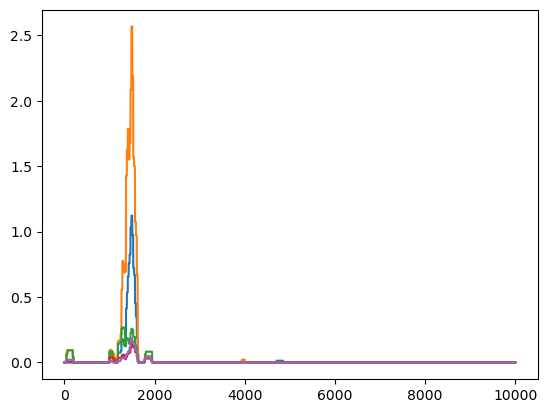

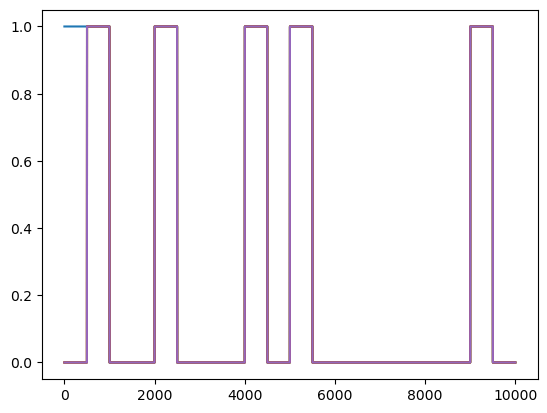

In [30]:
#let's find some values that may be masked, focusing on the first 5 cell types
import matplotlib.pyplot as plt
s = 190_000
e = s+10_000
#now plot the first 5 rows of the masked
plt.figure()
for i in range(5):
    plt.plot(acc_masked[i, s:e].numpy(), label=f'Cell type {i}')
    
#now on a new plot plot the masks
#make a new figure
plt.figure()
for i in range(5):
    plt.plot(acc_masked[i+674, s:e].numpy(), label=f'Cell type {i} mask')

In [32]:
#we see around 190000, the mask differs, let's check
acc_masked[:5, 190000:190100].t()

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],


In [36]:
acc_masked[674:674+5, 189999:190100].t() #ahh here we see a separate independent mask

tensor([[0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1

In [38]:
acc_masked[674:674+100,190_000]

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [42]:
#only the first cell type is seemingly masked
#I think this makes sense and seemds to be working as expected!!

acc_masked[:674,190000:190100].max(1).values

tensor([0.0000, 0.0952, 0.0927, 0.0050, 0.0213, 0.0363, 0.0230, 0.0524, 0.0378,
        0.0404, 0.0257, 0.0409, 0.0457, 0.1179, 0.1130, 0.0251, 0.0972, 0.0504,
        0.0000, 0.0404, 0.0436, 0.0689, 0.1102, 0.0638, 0.0000, 0.0412, 0.0000,
        0.1538, 0.0481, 0.0000, 0.0635, 0.0614, 0.0166, 0.0116, 0.0078, 0.0131,
        0.0773, 0.0628, 0.0505, 0.1544, 0.0075, 0.0648, 0.0000, 0.0591, 0.0203,
        0.0476, 0.0106, 0.0057, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0229, 0.0465, 0.0000, 0.0000, 0.0000, 0.0821, 0.0465, 0.0203, 0.0274,
        0.0000, 0.0000, 0.0000, 0.0064, 0.0000, 0.0341, 0.0379, 0.0415, 0.0134,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0101, 0.0000, 0.0221, 0.0072, 0.0223,
        0.0000, 0.0000, 0.0031, 0.0130, 0.0032, 0.0000, 0.0000, 0.0000, 0.0026,
        0.0000, 0.0300, 0.0164, 0.0000, 0.0232, 0.0119, 0.0306, 0.0000, 0.0000,
        0.0358, 0.0042, 0.0174, 0.0000, 0.0193, 0.0246, 0.0210, 0.0139, 0.0000,
        0.0305, 0.0158, 0.0067, 0.0170, 

In [ ]:
#let's see the unmasked
acc_unmask.t()[:674,190000:190100].max(1).values #matches for all but the ones that are masked

tensor([0.0473, 0.0952, 0.0927, 0.0050, 0.0213, 0.0363, 0.0230, 0.0524, 0.0378,
        0.0404, 0.0257, 0.0409, 0.0457, 0.1179, 0.1130, 0.0251, 0.0972, 0.0504,
        0.0000, 0.0404, 0.0436, 0.0689, 0.1102, 0.0638, 0.0000, 0.0412, 0.0000,
        0.1538, 0.0481, 0.0000, 0.0635, 0.0614, 0.0166, 0.0116, 0.0078, 0.0131,
        0.0773, 0.0628, 0.0505, 0.1544, 0.0075, 0.0648, 0.0000, 0.0591, 0.0203,
        0.0476, 0.0106, 0.0057, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0229, 0.0465, 0.0000, 0.0000, 0.0000, 0.0821, 0.0465, 0.0203, 0.0274,
        0.0000, 0.0000, 0.0000, 0.0064, 0.0000, 0.0341, 0.0379, 0.0415, 0.0134,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0101, 0.0000, 0.0221, 0.0072, 0.0223,
        0.0000, 0.0000, 0.0031, 0.0130, 0.0032, 0.0000, 0.0000, 0.0000, 0.0026,
        0.0000, 0.0300, 0.0164, 0.0000, 0.0232, 0.0119, 0.0306, 0.0000, 0.0000,
        0.0358, 0.0042, 0.0174, 0.0000, 0.0193, 0.0246, 0.0210, 0.0139, 0.0000,
        0.0305, 0.0158, 0.0067, 0.0170, 

In [49]:
#see which ones are masked
acc_unmask.t()[674:,190000:190100].max(1).values #seems to match exactly where the mask is

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 

In [45]:
acc_masked.shape, acc_unmask.shape

(torch.Size([1348, 524288]), torch.Size([524288, 1348]))

In [46]:
#some are truly zero, but that's really fine! I think this is good!
#let's double check to see that the masks match
torch.allclose(acc_masked[674:, :].t(), acc_unmask[:, 674:]) #should be true, and it is!

True

In [ ]:
#definitely seems fine to me, so long as we can give the right parameters and specify mask_only=True and mask_tie less than 1, seems to work well
#then we just have to make sure the encoder has the right number of channels, same with decoder. Should be 674*2 for encoder, 674 for decoder for accessibility. that's doutput2 for decoder and d_input2 for encoder
#shouldnl't need to add to dataloader?
acc_masked.dtype

torch.float32

In [8]:
#finally let's test for mask tie = 1
def mask_seq(seq, mask_pct=0.15, replace_with_N=True, span=1, stype='category', weights=None, mask_only=False, mask_tie=1):
    """This function will mask the sequence data, it does the BERT masking where you do 80% truly masked, 10% random, 10% unchanged
    Note that for random replacement, it cannot be the N token, sicne it's very rare anyways, always random nucleotide!
    Args:
        seq: the sequence to mask, this is a tensor of shape (length, N) if categorical, or (length,1) if continuous, N is the number of classes (5 for ohe nucleotide data)
        mask_pct: the percentage of the sequence to mask, default is 0.15 or 15%
        replace_with_N: whether to allow random replacement of values with N (for one hot encoded data). Keep True for other categorical data
        span: the size of the span to mask, default is 1, so it masks every element independently, but can be larger to mask chunks of size span
        stype: the type of sequence, 'category' for categorical like ohe nucleotide data and 'continuous' for continuous like raw accessibility data, default is 'category'
        weights: the weights to use for weighting regions like peaks. default is None, must be a tensor of shape (length,) to weight the peaks higher for masking. can be the same as the seq itself
        mask_only: whether to do the 10% unchanged and 10% random replacement, default is False. If True, will only do the 100% truly masked and leave the rest unchanged
        mask_tie: how much masking is tied across categories. 1 means fully tied, so all tracks are masked the same, 0 means fully indepdendent masking across categories. If true, returns slightlly different values
    Returns:
        seq: the masked sequence, this is a tensor of shape (length, N+1) or N*2 if mask_tie is less than 1 if categorical or (length, 2) if continuous, where the last column is the mask track (only tells if masked, some are random or unchanged)
        seq_unmask: the unmasked sequence, this is a tensor of shape (length, N+1) or N*2 if categorical or (length, 2), where the last column is the mask track (tells all elements that have been changed or goign to evaluate)
    """
    
    if len(seq.shape) == 1: #if it's just a 1D tensor, we need to add a dimension for the mask track
        seq = seq.unsqueeze(1) #so now it's shape length x 1, so we can concatenate other things
    
    extra_append = 0
    if seq.shape[0]%span != 0:
        #we append on values
        remainder = seq.shape[0] % span
        extra_append = span - remainder
        seq = torch.cat([seq, torch.zeros((extra_append,seq.shape[1]), dtype=torch.float)]) #so now we can have a mask for every element in the span, so size length again
    
    num_elements = seq.shape[0]//span #chunks into chunks of size span

    # Create a probability vector (one per token) and sample which tokens to mask
    probability_matrix = torch.full((num_elements,), mask_pct) #size of length, defines for each element if we mask it or not
    
    #we can also weight peak regions more
    if weights is not None:
        assert mask_tie == 1, "Weighting with weights is only supported for mask_tie=1 currently"
        weights = weights.squeeze()
        assert weights.ndim == 1, f"weights must be a 1D tensor, got {weights.shape}"

        #Trim weights to match the required size
        if weights.shape[0] % span != 0:
            #remove values until it is the right size
            weights = weights[:num_elements*span]
        
        #compute mean over spans
        weights = weights.view(num_elements, span).mean(1) #average the weights over the span, so now it's size length
        
        #normalize weights to have range 0.5 to 1.5
        weights = torch.log(weights + 1) #log transform to reduce the scale of values
        weights = (weights - weights.min()) / (weights.max() - weights.min()) + .5 #normalize to have different range, downweights small values, upweights large ones to almost 3x

        #scale probability matrix by weights
        probability_matrix = probability_matrix * weights #so now we have a weighted probability matrix, so we can mask more in peak regions
        #and scale up probability matrix so that the mean is mask_pct
        probability_matrix = probability_matrix / probability_matrix.mean() * mask_pct #so now we have a weighted probability matrix, so we can mask more in peak regions
        
        #clip to make sure between 0 and 1
        probability_matrix = torch.clamp(probability_matrix, min=0, max=1) #clip to make sure between 0 and 1     
    
    masked_indices = torch.bernoulli(probability_matrix.float()).bool() #finds which indices to mask, so shape is length, and is True or False for each index

    if mask_tie < 1: #have to implement own logic and loop, this is for the dependent tracks, otherwise unclear how to implement it, can make it like 0.999
        assert mask_only, "Not implemented for mask_only = False yet"
        extra = seq.shape[0] % span
        #first replicate masked_indices to be of shape length x num_categories
        masked_indices = masked_indices.unsqueeze(1).repeat(1, seq.shape[1])
        all_expanded_masked_indices = torch.zeros((seq.shape[0], seq.shape[1]), dtype=torch.bool)
        #now per row we need to randomly change some of the true and falses at the 1-mask_tie proportion
        
        #let's just loop over it. Not the best, I know, but it is the easiest
        base_mask = masked_indices[:,0].clone()
        num_masked = base_mask.sum().item()
        true_indices = torch.nonzero(base_mask).squeeze()
        false_indices = torch.nonzero(~base_mask).squeeze()
        # mask_positions = torch.zeros((masked_indices.shape[1], num_masked*span), dtype=torch.long) #preallocate max size
        q = 1-mask_tie
        for i in range(masked_indices.shape[1]):
            #now we find 10% of the true values and turn them to false, and then get the same amount and turn them from false to true
            num_change = int(num_masked * q)
            #randomly select num_change indices from true_indices and false_indices
            true_change_indices = true_indices[torch.randperm(true_indices.numel())[:num_change]]
            false_change_indices = false_indices[torch.randperm(false_indices.numel())[:num_change]]
            #now set them
            masked_indices[true_change_indices, i] = False
            masked_indices[false_change_indices, i] = True
            #also just do the steps to get all mask positions. This metric keeps the amount of true and false at least? then we also need to decide which ones are true mask which ones are random?
            #for now we can make it work with mask_only = True, this way we ignore the other things
            expanded_masked_indices = masked_indices[:,i].repeat_interleave(span)
            # print(expanded_masked_indices, expanded_masked_indices.shape)
            if extra > 0:
                expanded_masked_indices = torch.cat([expanded_masked_indices, torch.zeros(extra, dtype=torch.bool)]) #so now we have a mask for every element in the span, so size length again
            all_expanded_masked_indices[:,i] = expanded_masked_indices
            
            all_mask_positions = torch.nonzero(masked_indices[:,i]).squeeze()*span
            # print(all_mask_positions, all_mask_positions.shape)
            # mask_positions[i] = (all_mask_positions.unsqueeze(1) + torch.arange(span)).flatten()
            # print(mask_positions[i], mask_positions[i].shape) #was a dict because the size changes depending on how many elements are masked. Although it should be a set value..., yeah don't need dict
        
        seq_unmask = torch.zeros((seq.shape[0], seq.shape[1]*2), dtype=torch.float)
        seq_unmask[:, :seq.shape[1]] = seq
        seq_unmask[:, seq.shape[1]:] = all_expanded_masked_indices.float()
        seq_masked = seq_unmask.clone()
        # seq_masked = torch.zeros((seq.shape[0], seq.shape[1]*2), dtype=torch.float) #this should be a faster way to clone
        # seq_masked[:, :seq.shape[1]] = seq
        # seq_masked[:, seq.shape[1]:] = all_expanded_masked_indices.float()
        
        # seq_unmask = torch.cat([seq, all_expanded_masked_indices.float()], dim=1)
        # seq_masked = seq_unmask.clone()
        num_channels = seq.shape[1]
        seq_masked[:, :num_channels] = seq_masked[:, :num_channels] * (~all_expanded_masked_indices).float()
        if span > 1 and extra_append > 0:
            seq_masked = seq_masked[:-extra_append]
            seq_unmask = seq_unmask[:-extra_append]
        return seq_masked, seq_unmask #return the masked sequence and the unmasked sequence
    

    # Get positions that were chosen to be masked
    all_mask_positions = torch.nonzero(masked_indices).squeeze()*span #squeeze to remove the extra dimension, and multiply by span to get the actual positions in the original sequence
    num_masked = all_mask_positions.numel()
    
    # Determine counts for the three groups: 80% truly masked, 10% random, 10% unchanged
    num_mask = int(0.8 * num_masked)
    num_random = int(0.1 * num_masked)
    # To avoid rounding issues, let the remaining be unchanged
    # num_unchanged = num_masked - num_mask - num_random
    
    # Shuffle the masked positions to randomly assign each to a category
    permuted = all_mask_positions[torch.randperm(num_masked)]
    mask_positions = permuted[:num_mask]  # 80%: replace with mask token
    random_positions = permuted[num_mask:num_mask+num_random]  # 10%: random token
    unchanged_positions = permuted[num_mask+num_random:]  # 10%: leave as is

    if span > 1:
        masked_indices = masked_indices.repeat_interleave(span) #so now we have a mask for every element in the span, so size length again
        #and append zeros until the size of seq
        extra = seq.shape[0] % span
        if extra > 0:
            masked_indices = torch.cat([masked_indices, torch.zeros(extra, dtype=torch.bool)]) #so now we have a mask for every element in the span, so size length again
        
        #now for each of the positions, we need to expand and then make masking apply per index
        mask_positions = (mask_positions.unsqueeze(1) + torch.arange(span)).flatten()
        random_positions = (random_positions.unsqueeze(1) + torch.arange(span)).flatten()
        unchanged_positions = (unchanged_positions.unsqueeze(1) + torch.arange(span)).flatten()
        #and now they are grouped and we can just deal with them

    # Append the mask track to the sequence, resulting in a tensor of shape [seq_len, 6], or [seq_len, 2] if acc data
    # where the last column is the mask track
    seq_unmask = torch.cat([seq, masked_indices.unsqueeze(1).float()], dim=1) #so now seq_unmask is shape length x 6, where 6 is the 5 one hot classes and the mask
    
    seq_masked = seq_unmask.clone()  # Create a copy to modify, note that the mask track should be 0 for ones where it's not masked but is random or unchanged
    seq_masked[mask_positions, :-1] = 0  # Set to zero for every class but the last (tells it it's masked)
    
    if mask_only:
        #now forcibly mask the rest
        seq_masked[unchanged_positions, :-1] = 0  # Set to zero for every class but the last (tells it it's masked)
        seq_masked[random_positions, :-1] = 0  # Set to zero for every class but the last (tells it it's masked)
        if span > 1 and extra_append > 0:
            seq_masked = seq_masked[:-extra_append]
            seq_unmask = seq_unmask[:-extra_append]
        # print(seq_masked.shape)
        return seq_masked, seq_unmask #return the masked sequence and the unmasked sequence, so we can use it for the rest of the processing
    
    if stype == 'category':
        # print(f'random_positions shape: {random_positions.shape}, seq shape: {seq.shape}')
        if replace_with_N:
            random_max = seq.shape[1]
        else:
            random_max = seq.shape[1] - 1
        random_tokens = torch.randint(0, random_max, (random_positions.numel()//span,)) #generate random values for each position
        random_one_hot = torch.zeros((random_positions.numel()//span, seq.shape[1])) #one hot encode them
        random_one_hot.scatter_(1, random_tokens.unsqueeze(1), 1.0)
        #now repeat with the span
        random_one_hot = random_one_hot.repeat_interleave(span, dim=0) #so now we have a one hot for each position in the span
        seq_masked[random_positions, :seq.shape[1]] = random_one_hot #assign them to the set positions
        
    elif stype == 'continuous':
        #for accessibility, we will select random values from somewhere else in the sequence and then slightly shift and noise them
        #get a random value between 0 and len(seq)-span
        rand_start = torch.randint(0, seq.shape[0]-span, (random_positions.numel()//span,)) #definitely divisble by span since it was extended by size span
        rand_idx = (rand_start.unsqueeze(1) + torch.arange(span)) #so now we have a random index for each of the random positions, and we can just select from there
        rand_vals = seq.squeeze(1)[rand_idx] #get the values from the sequence at those random positions, so now we have a random value for each of the random positions
        #and we can add some noise to it, so we can just add a small random value to it. Noise will be values between -0.1 and 0.1
        rand_vals_mean = rand_vals.mean(1, keepdim=True) #get the mean of the random values for each position, keeps the dim so we can broadcast it
        noise = torch.randn(rand_vals.shape) * rand_vals_mean * 0.1 #gaussian noise with std of 0.1 times the mean of the random values, so we can add some larger nosie to larger values
        rand_vals = torch.clamp((rand_vals + noise).flatten(), min = 0) #make sure values are at least 0, else obvious there's noise in the region
        #and now set the values
        seq_masked[random_positions, 0] = rand_vals #set the values to the random values with noise, so now we have a random value for each of the random positions
    
    else:
        raise ValueError("stype must be either 'category' or 'continuous'")
    
    #and remove the masked value, it doesn't know it's masked
    seq_masked[random_positions, -1] = 0
    
    #and we remove the mask token from the unchanged value
    seq_masked[unchanged_positions, -1] = 0
    # seq = seq_masked #now we have the masked sequence, so we can use this for the rest of the processing

    if span > 1 and extra_append > 0:
        seq_masked = seq_masked[:-extra_append]
        seq_unmask = seq_unmask[:-extra_append]
    
    return seq_masked, seq_unmask #return the masked sequence and the unmasked sequence, so we can use it for the rest of the processing

seq = torch.ones((100_000,50))
seq_masked, seq_unmask = mask_seq(seq, mask_pct=0.3, replace_with_N=True, span=10, stype='category', weights=None, mask_only=True, mask_tie=1)
print(seq_masked.shape, seq_unmask.shape)

torch.Size([100000, 51]) torch.Size([100000, 51])


In [9]:
#now let's test it and make sure each row of seq_masked is the same
for i in range(50):
    assert torch.allclose(seq_masked[:,i], seq_masked[:,0])

In [ ]:
#yeah, seems right?
seq_masked[:40,-10:] #yeah it seems to work well!!

tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 0.],


# some more updates

change the way mask tie functions

In [1]:
import torch
num_categories = 10
seq = torch.ones((20,num_categories))

In [2]:
# basically mask tie will change the values of 1-mask_tie values, and unmask 10% of them
import torch
def mask_seq(seq, mask_pct=0.15, replace_with_N=True, span=1, stype='category', weights=None, mask_only=False, mask_tie=1):
    """This function will mask the sequence data, it does the BERT masking where you do 80% truly masked, 10% random, 10% unchanged
    Note that for random replacement, it cannot be the N token, sicne it's very rare anyways, always random nucleotide!
    Args:
        seq: the sequence to mask, this is a tensor of shape (length, N) if categorical, or (length,1) if continuous, N is the number of classes (5 for ohe nucleotide data)
        mask_pct: the percentage of the sequence to mask, default is 0.15 or 15%
        replace_with_N: whether to allow random replacement of values with N (for one hot encoded data). Keep True for other categorical data
        span: the size of the span to mask, default is 1, so it masks every element independently, but can be larger to mask chunks of size span
        stype: the type of sequence, 'category' for categorical like ohe nucleotide data and 'continuous' for continuous like raw accessibility data, default is 'category'
        weights: the weights to use for weighting regions like peaks. default is None, must be a tensor of shape (length,) to weight the peaks higher for masking. can be the same as the seq itself
        mask_only: whether to do the 10% unchanged and 10% random replacement, default is False. If True, will only do the 100% truly masked and leave the rest unchanged
        mask_tie: how much masking is tied across categories. 1 means fully tied, so all tracks are masked the same, 0 means fully indepdendent masking across categories. If true, returns slightlly different values
    Returns:
        seq: the masked sequence, this is a tensor of shape (length, N+1) or N*2 if mask_tie is less than 1 if categorical or (length, 2) if continuous, where the last column is the mask track (only tells if masked, some are random or unchanged)
        seq_unmask: the unmasked sequence, this is a tensor of shape (length, N+1) or N*2 if categorical or (length, 2), where the last column is the mask track (tells all elements that have been changed or goign to evaluate)
    """
    
    if len(seq.shape) == 1: #if it's just a 1D tensor, we need to add a dimension for the mask track
        seq = seq.unsqueeze(1) #so now it's shape length x 1, so we can concatenate other things
    
    extra_append = 0
    if seq.shape[0]%span != 0:
        #we append on values
        remainder = seq.shape[0] % span
        extra_append = span - remainder
        seq = torch.cat([seq, torch.zeros((extra_append,seq.shape[1]), dtype=torch.float)]) #so now we can have a mask for every element in the span, so size length again
    
    num_elements = seq.shape[0]//span #chunks into chunks of size span

    # Create a probability vector (one per token) and sample which tokens to mask
    probability_matrix = torch.full((num_elements,), mask_pct) #size of length, defines for each element if we mask it or not
    
    #we can also weight peak regions more
    if weights is not None:
        assert mask_tie == 1, "Weighting with weights is only supported for mask_tie=1 currently"
        weights = weights.squeeze()
        assert weights.ndim == 1, f"weights must be a 1D tensor, got {weights.shape}"

        #Trim weights to match the required size
        if weights.shape[0] % span != 0:
            #remove values until it is the right size
            weights = weights[:num_elements*span]
        
        #compute mean over spans
        weights = weights.view(num_elements, span).mean(1) #average the weights over the span, so now it's size length
        
        #normalize weights to have range 0.5 to 1.5
        weights = torch.log(weights + 1) #log transform to reduce the scale of values
        weights = (weights - weights.min()) / (weights.max() - weights.min()) + .5 #normalize to have different range, downweights small values, upweights large ones to almost 3x

        #scale probability matrix by weights
        probability_matrix = probability_matrix * weights #so now we have a weighted probability matrix, so we can mask more in peak regions
        #and scale up probability matrix so that the mean is mask_pct
        probability_matrix = probability_matrix / probability_matrix.mean() * mask_pct #so now we have a weighted probability matrix, so we can mask more in peak regions
        
        #clip to make sure between 0 and 1
        probability_matrix = torch.clamp(probability_matrix, min=0, max=1) #clip to make sure between 0 and 1     
    
    masked_indices = torch.bernoulli(probability_matrix.float()).bool() #finds which indices to mask, so shape is length, and is True or False for each index

    if mask_tie < 1: #have to implement own logic and loop, this is for the dependent tracks, otherwise unclear how to implement it, can make it like 0.999
        assert mask_only, "Not implemented for mask_only = False yet"
        extra = seq.shape[0] % span
        #first replicate masked_indices to be of shape length x num_categories
        masked_indices = masked_indices.unsqueeze(1).repeat(1, seq.shape[1])
        all_expanded_masked_indices = torch.zeros((seq.shape[0], seq.shape[1]), dtype=torch.bool)
        # print(masked_indices.shape, all_expanded_masked_indices.shape) length/span x categories, length x categories 
        #now per row we need to randomly change some of the true and falses at the 1-mask_tie proportion
        
        #let's just loop over it. Not the best, I know, but it is the easiest
        base_mask = masked_indices[:,0].clone()
        num_masked = base_mask.sum().item()
        true_indices = torch.nonzero(base_mask).squeeze()
        false_indices = torch.nonzero(~base_mask).squeeze()
        # mask_positions = torch.zeros((masked_indices.shape[1], num_masked*span), dtype=torch.long) #preallocate max size
        q = 1-mask_tie
        for i in range(masked_indices.shape[1]):
            #now we find 10% of the true values and turn them to false, and then get the same amount and turn them from false to true
            num_change = int(num_masked * q)
            #randomly select num_change indices from true_indices and false_indices
            true_change_indices = true_indices[torch.randperm(true_indices.numel())[:num_change]]
            false_change_indices = false_indices[torch.randperm(false_indices.numel())[:num_change]]
            #now set them
            masked_indices[true_change_indices, i] = False
            masked_indices[false_change_indices, i] = True
            #also just do the steps to get all mask positions. This metric keeps the amount of true and false at least? then we also need to decide which ones are true mask which ones are random?
            #for now we can make it work with mask_only = True, this way we ignore the other things
            expanded_masked_indices = masked_indices[:,i].repeat_interleave(span)
            # print(expanded_masked_indices, expanded_masked_indices.shape)
            if extra > 0:
                expanded_masked_indices = torch.cat([expanded_masked_indices, torch.zeros(extra, dtype=torch.bool)]) #so now we have a mask for every element in the span, so size length again
            all_expanded_masked_indices[:,i] = expanded_masked_indices
            
            # all_mask_positions = torch.nonzero(masked_indices[:,i]).squeeze()*span
            # print(all_mask_positions, all_mask_positions.shape)
            # mask_positions[i] = (all_mask_positions.unsqueeze(1) + torch.arange(span)).flatten()
            # print(mask_positions[i], mask_positions[i].shape) #was a dict because the size changes depending on how many elements are masked. Although it should be a set value..., yeah don't need dict
        
        # print(all_expanded_masked_indices.shape, all_expanded_masked_indices) #same size as initial data, just now tells you if true or false!
        seq_unmask = torch.zeros((seq.shape[0], seq.shape[1]*2), dtype=torch.float)
        seq_unmask[:, :seq.shape[1]] = seq
        seq_unmask[:, seq.shape[1]:] = all_expanded_masked_indices.float()
        seq_masked = seq_unmask.clone()
        # seq_masked = torch.zeros((seq.shape[0], seq.shape[1]*2), dtype=torch.float) #this should be a faster way to clone
        # seq_masked[:, :seq.shape[1]] = seq
        # seq_masked[:, seq.shape[1]:] = all_expanded_masked_indices.float()
        
        # seq_unmask = torch.cat([seq, all_expanded_masked_indices.float()], dim=1)
        # seq_masked = seq_unmask.clone()
        num_channels = seq.shape[1]
        seq_masked[:, :num_channels] = seq_masked[:, :num_channels] * (~all_expanded_masked_indices).float()
        if span > 1 and extra_append > 0:
            seq_masked = seq_masked[:-extra_append]
            seq_unmask = seq_unmask[:-extra_append]
        return seq_masked, seq_unmask #return the masked sequence and the unmasked sequence
    


In [3]:
mask_pct=0.3
replace_with_N=True
span=2
mask_only=True
stype='category'
weights=None
mask_tie=0.5
num_categories = 10
seq = torch.ones((30,num_categories))

seq_masked, seq_unmask = mask_seq(seq, mask_pct=mask_pct, replace_with_N=replace_with_N, span=span, stype=stype, weights=weights, mask_only=mask_only, mask_tie=mask_tie)

#

In [4]:
#ok so by changing this, it will actually be incredibly fast, no need for loops!! This is much better!
#can also rewrite so much of it!!

import torch
def mask_seq(seq, mask_pct=0.15, replace_with_N=True, span=1, stype='category', weights=None, mask_only=False, mask_tie=1):
    """This function will mask the sequence data, it does the BERT masking where you do 80% truly masked, 10% random, 10% unchanged
    Note that for random replacement, it cannot be the N token, sicne it's very rare anyways, always random nucleotide!
    Args:
        seq: the sequence to mask, this is a tensor of shape (length, N) if categorical, or (length,1) if continuous, N is the number of classes (5 for ohe nucleotide data)
        mask_pct: the percentage of the sequence to mask, default is 0.15 or 15%
        replace_with_N: whether to allow random replacement of values with N (for one hot encoded data). Keep True for other categorical data
        span: the size of the span to mask, default is 1, so it masks every element independently, but can be larger to mask chunks of size span
        stype: the type of sequence, 'category' for categorical like ohe nucleotide data and 'continuous' for continuous like raw accessibility data, default is 'category'
        weights: the weights to use for weighting regions like peaks. default is None, must be a tensor of shape (length,) to weight the peaks higher for masking. can be the same as the seq itself
        mask_only: whether to do the 10% unchanged and 10% random replacement, default is False. If True, will only do the 100% truly masked and leave the rest unchanged
        mask_tie: how much masking is tied across categories. 1 means fully tied, so all tracks are masked the same, 0 means fully indepdendent masking across categories. If true, returns slightlly different values
    Returns:
        seq: the masked sequence, this is a tensor of shape (length, N+1) or N*2 if mask_tie is less than 1 if categorical or (length, 2) if continuous, where the last column is the mask track (only tells if masked, some are random or unchanged)
        seq_unmask: the unmasked sequence, this is a tensor of shape (length, N+1) or N*2 if categorical or (length, 2), where the last column is the mask track (tells all elements that have been changed or goign to evaluate)
    """
    
    if len(seq.shape) == 1: #if it's just a 1D tensor, we need to add a dimension for the mask track
        seq = seq.unsqueeze(1) #so now it's shape length x 1, so we can concatenate other things
    
    extra_append = 0
    if seq.shape[0]%span != 0:
        #we append on values
        remainder = seq.shape[0] % span
        extra_append = span - remainder
        seq = torch.cat([seq, torch.zeros((extra_append,seq.shape[1]), dtype=torch.float)]) #so now we can have a mask for every element in the span, so size length again
    
    num_elements = seq.shape[0]//span #chunks into chunks of size span

    # Create a probability vector (one per token) and sample which tokens to mask
    probability_matrix = torch.full((num_elements,), mask_pct) #size of length, defines for each element if we mask it or not
    
    #we can also weight peak regions more
    if weights is not None:
        assert mask_tie == 1, "Weighting with weights is only supported for mask_tie=1 currently"
        weights = weights.squeeze()
        assert weights.ndim == 1, f"weights must be a 1D tensor, got {weights.shape}"

        #Trim weights to match the required size
        if weights.shape[0] % span != 0:
            #remove values until it is the right size
            weights = weights[:num_elements*span]
        
        #compute mean over spans
        weights = weights.view(num_elements, span).mean(1) #average the weights over the span, so now it's size length
        
        #normalize weights to have range 0.5 to 1.5
        weights = torch.log(weights + 1) #log transform to reduce the scale of values
        weights = (weights - weights.min()) / (weights.max() - weights.min()) + .5 #normalize to have different range, downweights small values, upweights large ones to almost 3x

        #scale probability matrix by weights
        probability_matrix = probability_matrix * weights #so now we have a weighted probability matrix, so we can mask more in peak regions
        #and scale up probability matrix so that the mean is mask_pct
        probability_matrix = probability_matrix / probability_matrix.mean() * mask_pct #so now we have a weighted probability matrix, so we can mask more in peak regions
        
        #clip to make sure between 0 and 1
        probability_matrix = torch.clamp(probability_matrix, min=0, max=1) #clip to make sure between 0 and 1     
    
    masked_indices = torch.bernoulli(probability_matrix.float()).bool() #finds which indices to mask, so shape is length, and is True or False for each index

    if mask_tie < 1: #have to implement own logic and loop, this is for the dependent tracks, otherwise unclear how to implement it, can make it like 0.999
        assert mask_only, "Not implemented for mask_only = False yet"
        extra = seq.shape[0] % span
        
        expanded_mask = masked_indices.repeat_interleave(span) #so now we have a mask for every element in the span, so size length again
        
        #first replicate masked_indices to be of shape length x num_categories
        masked_indices = masked_indices.unsqueeze(1).repeat(1, seq.shape[1])
        all_expanded_masked_indices = torch.zeros((seq.shape[0], seq.shape[1]), dtype=torch.bool)
        # print(masked_indices.shape, all_expanded_masked_indices.shape) length/span x categories, length x categories 
        #now per row we need to randomly change some of the true and falses at the 1-mask_tie proportion
        
        #let's just loop over it. Not the best, I know, but it is the easiest
        base_mask = masked_indices[:,0].clone()
        num_masked = base_mask.sum().item()
        true_indices = torch.nonzero(base_mask).squeeze()
        false_indices = torch.nonzero(~base_mask).squeeze()
        
        #now expand the base mask to full size
        expanded_base_mask = base_mask.repeat_interleave(span)
        if extra > 0:
            expanded_base_mask = torch.cat([expanded_base_mask, torch.zeros(extra, dtype=torch.bool)]) #so now we have a mask for every element in the span, so size length again
        
        #now we repeat it to make same size as all
        all_expanded_mask = expanded_base_mask.unsqueeze(1).repeat(1, seq.shape[1])
        print(all_expanded_mask.shape, all_expanded_mask, sep='\n')
        
        return None

In [5]:
mask_seq(seq, mask_pct=mask_pct, replace_with_N=replace_with_N, span=span, stype=stype, weights=weights, mask_only=mask_only, mask_tie=mask_tie)
#currently haven't yuet implemented the part where it differs

torch.Size([30, 10])
tensor([[False, False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True],
        [ True,  Tr

In [28]:
def mask_seq(seq, mask_pct=0.15, replace_with_N=True, span=1, stype='category', weights=None, mask_only=False, mask_tie=1):
    """This function will mask the sequence data, it does the BERT masking where you do 80% truly masked, 10% random, 10% unchanged
    Note that for random replacement, it cannot be the N token, sicne it's very rare anyways, always random nucleotide!
    Args:
        seq: the sequence to mask, this is a tensor of shape (length, N) if categorical, or (length,1) if continuous, N is the number of classes (5 for ohe nucleotide data)
        mask_pct: the percentage of the sequence to mask, default is 0.15 or 15%
        replace_with_N: whether to allow random replacement of values with N (for one hot encoded data). Keep True for other categorical data
        span: the size of the span to mask, default is 1, so it masks every element independently, but can be larger to mask chunks of size span
        stype: the type of sequence, 'category' for categorical like ohe nucleotide data and 'continuous' for continuous like raw accessibility data, default is 'category'
        weights: the weights to use for weighting regions like peaks. default is None, must be a tensor of shape (length,) to weight the peaks higher for masking. can be the same as the seq itself
        mask_only: whether to do the 10% unchanged and 10% random replacement, default is False. If True, will only do the 100% truly masked and leave the rest unchanged
        mask_tie: how much masking is tied across categories. 1 means fully tied, so all tracks are masked the same, 0 means fully indepdendent masking across categories. If true, returns slightlly different values
    Returns:
        seq: the masked sequence, this is a tensor of shape (length, N+1) or N*2 if mask_tie is less than 1 if categorical or (length, 2) if continuous, where the last column is the mask track (only tells if masked, some are random or unchanged)
        seq_unmask: the unmasked sequence, this is a tensor of shape (length, N+1) or N*2 if categorical or (length, 2), where the last column is the mask track (tells all elements that have been changed or goign to evaluate)
    """
    
    if len(seq.shape) == 1: #if it's just a 1D tensor, we need to add a dimension for the mask track
        seq = seq.unsqueeze(1) #so now it's shape length x 1, so we can concatenate other things
    
    extra_append = 0
    if seq.shape[0]%span != 0:
        #we append on values
        remainder = seq.shape[0] % span
        extra_append = span - remainder
        seq = torch.cat([seq, torch.zeros((extra_append,seq.shape[1]), dtype=torch.float)]) #so now we can have a mask for every element in the span, so size length again
    
    num_elements = seq.shape[0]//span #chunks into chunks of size span

    # Create a probability vector (one per token) and sample which tokens to mask
    probability_matrix = torch.full((num_elements,), mask_pct) #size of length, defines for each element if we mask it or not
    
    #we can also weight peak regions more
    if weights is not None:
        assert mask_tie == 1, "Weighting with weights is only supported for mask_tie=1 currently"
        weights = weights.squeeze()
        assert weights.ndim == 1, f"weights must be a 1D tensor, got {weights.shape}"

        #Trim weights to match the required size
        if weights.shape[0] % span != 0:
            #remove values until it is the right size
            weights = weights[:num_elements*span]
        
        #compute mean over spans
        weights = weights.view(num_elements, span).mean(1) #average the weights over the span, so now it's size length
        
        #normalize weights to have range 0.5 to 1.5
        weights = torch.log(weights + 1) #log transform to reduce the scale of values
        weights = (weights - weights.min()) / (weights.max() - weights.min()) + .5 #normalize to have different range, downweights small values, upweights large ones to almost 3x

        #scale probability matrix by weights
        probability_matrix = probability_matrix * weights #so now we have a weighted probability matrix, so we can mask more in peak regions
        #and scale up probability matrix so that the mean is mask_pct
        probability_matrix = probability_matrix / probability_matrix.mean() * mask_pct #so now we have a weighted probability matrix, so we can mask more in peak regions
        
        #clip to make sure between 0 and 1
        probability_matrix = torch.clamp(probability_matrix, min=0, max=1) #clip to make sure between 0 and 1     
    
    masked_indices = torch.bernoulli(probability_matrix.float()).bool() #finds which indices to mask, so shape is length//span, and is True or False for each index

    if mask_tie < 1: #have to implement own logic and loop, this is for the dependent tracks, otherwise unclear how to implement it, can make it like 0.999? should actually work for mask only true if mask tie is 1
        assert mask_only, "Not implemented for mask_only = False yet"
        extra = seq.shape[0] % span

        all_masked_indices = masked_indices.unsqueeze(1).repeat(1, seq.shape[1])
        # print(all_masked_indices.shape) #shape is length//span x num_categories
        #now we find which ones will change based on mask_tie and only changing the masks to be unmasked
        change = masked_indices & (torch.rand(masked_indices.shape) < (1 - mask_tie))
        # print(change.shape, change) #shape is length//span
        flip = change.unsqueeze(1) & (torch.rand_like(all_masked_indices.float()) < 0.10)
        all_masked_indices = all_masked_indices & (~flip)
        return flip, change, all_masked_indices
        # all_masked_indices
        for i in range(change):
            2
        
        expanded_mask = masked_indices.repeat_interleave(span) #so now we have a mask for every element in the span, so size length again
        all_expanded_mask = expanded_base_mask.unsqueeze(1).repeat(1, seq.shape[1])
        
        #first replicate masked_indices to be of shape length x num_categories
        masked_indices = masked_indices.unsqueeze(1).repeat(1, seq.shape[1])
        all_expanded_masked_indices = torch.zeros((seq.shape[0], seq.shape[1]), dtype=torch.bool)
        # print(masked_indices.shape, all_expanded_masked_indices.shape) length/span x categories, length x categories 
        #now per row we need to randomly change some of the true and falses at the 1-mask_tie proportion
        
        #let's just loop over it. Not the best, I know, but it is the easiest
        base_mask = masked_indices[:,0].clone()
        num_masked = base_mask.sum().item()
        true_indices = torch.nonzero(base_mask).squeeze()
        false_indices = torch.nonzero(~base_mask).squeeze()
        
        #now expand the base mask to full size
        expanded_base_mask = base_mask.repeat_interleave(span)
        if extra > 0:
            expanded_base_mask = torch.cat([expanded_base_mask, torch.zeros(extra, dtype=torch.bool)]) #so now we have a mask for every element in the span, so size length again
        
        #now we repeat it to make same size as all

        #now we find the number to change
        num_change = int(num_masked * q)

In [33]:
mask_pct=0.3
replace_with_N=True
span=2
mask_only=True
stype='category'
weights=None
mask_tie=0.5
num_categories = 10
seq = torch.ones((30,num_categories))
flip,change,allmask = mask_seq(seq, mask_pct=mask_pct, replace_with_N=replace_with_N, span=span, stype=stype, weights=weights, mask_only=mask_only, mask_tie=mask_tie)

In [34]:
change.shape, flip.shape

(torch.Size([15]), torch.Size([15, 10]))

In [ ]:
change #only the 5th element in the sequence can have any true for example, so first 4 rows should be false only

tensor([False, False, False, False, False,  True, False,  True, False, False,
        False, False,  True, False, False])

In [37]:
flip

tensor([[False, False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False],
        [False, False, False,  True, False, False,  True, False, False, False],
        [False, False, False, False, False, False, False, False, False, False],
        [ True, False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False],
        [False, False, False,  True, Fal

In [ ]:
allmask #indeed see some True becoming false, otherwise rows are identical!!

tensor([[False, False, False, False, False, False, False, False, False, False],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True],
        [False, False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False],
        [ True,  True,  True, False,  True,  True, False,  True,  True,  True],
        [False, False, False, False, False, False, False, False, False, False],
        [False,  True,  True,  True,  True,  True,  True,  True,  True,  True],
        [False, False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False],
        [ True,  True,  True, False,  Tr

In [ ]:
#now let's finish tthe function

def mask_seq(seq, mask_pct=0.15, replace_with_N=True, span=1, stype='category', weights=None, mask_only=False, mask_tie=1):
    """This function will mask the sequence data, it does the BERT masking where you do 80% truly masked, 10% random, 10% unchanged
    Note that for random replacement, it cannot be the N token, sicne it's very rare anyways, always random nucleotide!
    Args:
        seq: the sequence to mask, this is a tensor of shape (length, N) if categorical, or (length,1) if continuous, N is the number of classes (5 for ohe nucleotide data)
        mask_pct: the percentage of the sequence to mask, default is 0.15 or 15%
        replace_with_N: whether to allow random replacement of values with N (for one hot encoded data). Keep True for other categorical data
        span: the size of the span to mask, default is 1, so it masks every element independently, but can be larger to mask chunks of size span
        stype: the type of sequence, 'category' for categorical like ohe nucleotide data and 'continuous' for continuous like raw accessibility data, default is 'category'
        weights: the weights to use for weighting regions like peaks. default is None, must be a tensor of shape (length,) to weight the peaks higher for masking. can be the same as the seq itself
        mask_only: whether to do the 10% unchanged and 10% random replacement, default is False. If True, will only do the 100% truly masked and leave the rest unchanged
        mask_tie: how much masking is tied across categories. 1 means fully tied, so all tracks are masked the same, 0 means fully indepdendent masking across categories. If true, returns slightlly different values
    Returns:
        seq: the masked sequence, this is a tensor of shape (length, N+1) or N*2 if mask_tie is less than 1 if categorical or (length, 2) if continuous, where the last column is the mask track (only tells if masked, some are random or unchanged)
        seq_unmask: the unmasked sequence, this is a tensor of shape (length, N+1) or N*2 if categorical or (length, 2), where the last column is the mask track (tells all elements that have been changed or goign to evaluate)
    """
    
    if len(seq.shape) == 1: #if it's just a 1D tensor, we need to add a dimension for the mask track
        seq = seq.unsqueeze(1) #so now it's shape length x 1, so we can concatenate other things
    
    extra_append = 0
    if seq.shape[0]%span != 0:
        #we append on values
        remainder = seq.shape[0] % span
        extra_append = span - remainder
        seq = torch.cat([seq, torch.zeros((extra_append,seq.shape[1]), dtype=torch.float)]) #so now we can have a mask for every element in the span, so size length again
    
    num_elements = seq.shape[0]//span #chunks into chunks of size span

    # Create a probability vector (one per token) and sample which tokens to mask
    probability_matrix = torch.full((num_elements,), mask_pct) #size of length, defines for each element if we mask it or not
    
    #we can also weight peak regions more
    if weights is not None:
        assert mask_tie == 1, "Weighting with weights is only supported for mask_tie=1 currently"
        weights = weights.squeeze()
        assert weights.ndim == 1, f"weights must be a 1D tensor, got {weights.shape}"

        #Trim weights to match the required size
        if weights.shape[0] % span != 0:
            #remove values until it is the right size
            weights = weights[:num_elements*span]
        
        #compute mean over spans
        weights = weights.view(num_elements, span).mean(1) #average the weights over the span, so now it's size length
        
        #normalize weights to have range 0.5 to 1.5
        weights = torch.log(weights + 1) #log transform to reduce the scale of values
        weights = (weights - weights.min()) / (weights.max() - weights.min()) + .5 #normalize to have different range, downweights small values, upweights large ones to almost 3x

        #scale probability matrix by weights
        probability_matrix = probability_matrix * weights #so now we have a weighted probability matrix, so we can mask more in peak regions
        #and scale up probability matrix so that the mean is mask_pct
        probability_matrix = probability_matrix / probability_matrix.mean() * mask_pct #so now we have a weighted probability matrix, so we can mask more in peak regions
        
        #clip to make sure between 0 and 1
        probability_matrix = torch.clamp(probability_matrix, min=0, max=1) #clip to make sure between 0 and 1     
    
    masked_indices = torch.bernoulli(probability_matrix.float()).bool() #finds which indices to mask, so shape is length//span, and is True or False for each index

    if mask_tie < 1: #have to implement own logic and loop, this is for the dependent tracks, otherwise unclear how to implement it, can make it like 0.999? should actually work for mask only true if mask tie is 1
        assert mask_only, "Not implemented for mask_only = False yet"

        all_masked_indices = masked_indices.unsqueeze(1).repeat(1, seq.shape[1])
        # print(all_masked_indices.shape) #shape is length//span x num_categories
        #now we find which ones will change based on mask_tie and only changing the masks to be unmasked
        change = masked_indices & (torch.rand(masked_indices.shape) < (1 - mask_tie))
        # print(change.shape, change) #shape is length//span
        flip = change.unsqueeze(1) & (torch.rand_like(all_masked_indices.float()) < 0.10)
        all_masked_indices = all_masked_indices & (~flip)
        #and expand to full size
        all_expanded_masked_indices = all_masked_indices.repeat_interleave(span, dim=0)
        # if extra > 0:
        #     all_expanded_masked_indices = torch.cat([all_expanded_masked_indices, torch.zeros((extra, seq.shape[1]), dtype=torch.bool)]) #so now we have a mask for every element in the span, so size length again
        
        #now we can create the masked and unmasked sequences
        seq_unmask = torch.zeros((seq.shape[0], seq.shape[1]*2), dtype=torch.float)
        seq_unmask[:, :seq.shape[1]] = seq
        seq_unmask[:, seq.shape[1]:] = all_expanded_masked_indices.float()
        seq_masked = seq_unmask.clone()

        seq_masked[:, :seq.shape[1]] = seq_masked[:, :seq.shape[1]] * (~all_expanded_masked_indices).float()
        if span > 1 and extra_append > 0:
            seq_masked = seq_masked[:-extra_append]
            seq_unmask = seq_unmask[:-extra_append]
        return seq_masked, seq_unmask

In [40]:
seq_mask, seq_unmask = mask_seq(seq, mask_pct=mask_pct, replace_with_N=replace_with_N, span=span, stype=stype, weights=weights, mask_only=mask_only, mask_tie=mask_tie)
seq_mask.shape, seq_unmask.shape

(torch.Size([30, 20]), torch.Size([30, 20]))

In [43]:
seq_mask.int()

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1,

In [ ]:
seq_unmask.int() #the original data, left half should all be 1, right half tells you if masked or not!!

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1,

In [58]:
#it looks good, let's see what happens if span is 7
mask_pct=0.3
replace_with_N=True
span=3
mask_only=True
stype='category'
weights=None
mask_tie=0.5
num_categories = 5
seq = torch.ones((20,num_categories))
seq_mask, seq_unmask = mask_seq(seq, mask_pct=mask_pct, replace_with_N=replace_with_N, span=span, stype=stype, weights=weights, mask_only=mask_only, mask_tie=mask_tie)
seq_mask.shape, seq_unmask.shape

(torch.Size([20, 10]), torch.Size([20, 10]))

In [59]:
seq_mask.int()

tensor([[0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 1, 1, 1, 1]], dtype=torch.int32)

In [60]:
seq_unmask.int()

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=torch.int32)

In [ ]:
#looks and works exactly as expected, but mask tie seems off??
seq_mask, seq_unmask = mask_seq(seq, mask_pct=mask_pct, replace_with_N=replace_with_N, span=span, stype=stype, weights=weights, mask_only=mask_only, mask_tie=mask_tie)
seq_mask.int() #ok this seems right, mask tie is just way too rare??

tensor([[0, 1, 0, 0, 0, 1, 0, 1, 1, 1],
        [0, 1, 0, 0, 0, 1, 0, 1, 1, 1],
        [0, 1, 0, 0, 0, 1, 0, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 0, 0, 0, 0, 0]], dtype=torch.int32)

In [ ]:
seq_mask, seq_unmask = mask_seq(seq, mask_pct=mask_pct, replace_with_N=replace_with_N, span=span, stype=stype, weights=weights, mask_only=mask_only, mask_tie=mask_tie)
seq_mask.int() #ok this seems right, mask tie is just way too rare?? I think this is fine actually? let's just run it!

tensor([[1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 1, 0, 1, 1, 1, 0, 1],
        [0, 0, 0, 1, 0, 1, 1, 1, 0, 1],
        [0, 0, 0, 1, 0, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 0, 0, 0, 0, 0]], dtype=torch.int32)